In [30]:
#####################################################################################################################
#                                                                                                                   #
# Libraries                                                                                                         #
#                                                                                                                   #
#####################################################################################################################
from matplotlib import pyplot as plt

plt.rcParams['figure.dpi'] = 200 # Plot resolution (dpi)
import pandas as pd
import numpy as np
import os
from scipy import stats
from itertools import combinations
import seaborn as sns
from scipy.stats import friedmanchisquare, wilcoxon
import scikit_posthocs as sp
import itertools
from IPython.display import display
from scipy.stats import shapiro



In [31]:
file_path = '/Users/bodamjerry/Downloads/GermanyMacroData/'
os.chdir(file_path)
print(f"Current working directory: {os.getcwd()}")

t_Data_Dir = 'TData/'
r_State_Dir = "RState/"
f_result_Dir = "ForecastResults/"
m_result_Dir = "MAEsResults/"
r_result_Dir = "RMSEsResults/"


Current working directory: /Users/bodamjerry/Downloads/GermanyMacroData


In [32]:
read_dir = "cpi_multi_step_model_results/"
# os.makedirs(read_dir, exist_ok=True)
# Load the wide-format forecast file
forecast_df = pd.read_csv(filepath_or_buffer = read_dir + 'all_forecasts.csv', index_col=0)
mae_df = pd.read_csv(filepath_or_buffer = read_dir + 'all_mae.csv', index_col=0)
rmse_df = pd.read_csv(filepath_or_buffer = read_dir + 'all_rmse.csv', index_col=0)
# # Load the wide-format forecast file
# forecast_df = pd.read_csv("all_forecasts.csv", index_col=0)

In [33]:
print(len(forecast_df))

100


In [34]:
def plot_metric_with_std(metric_df, title):
    plt.figure(figsize=(10, 6))
    for col in metric_df.columns:
        mean_vals = metric_df[col].mean()
        std_vals = metric_df[col].std()
        plt.errorbar([col], [mean_vals], yerr=[std_vals], fmt='o', capsize=5, label=col)

    plt.title(f"{title} Across 100 Sliding Samples (Mean ± Std Dev)")
    plt.ylabel(title)
    plt.xticks(rotation=45)
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    # plt.grid(False)
    plt.tight_layout()
    plt.show()


def boxplot_metric_distribution(metric_df, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=metric_df, palette="Set3")
    plt.title(f"{title} Distribution Across 100 Rolling Samples")
    plt.ylabel(title)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_mae_mirror_barplot(mae_df, title="Mirror Barplot of MAE and Deviation"):
    """
    Creates a mirror barplot showing average MAE (right) and its deviation (left) for each model.
    Parameters:
    - mae_df: DataFrame where each column is a model and each row is an iteration
    """
    # Drop Iteration column if present
    df = mae_df.drop(columns='Iteration', errors='ignore')
    # Compute mean and std
    mae_means = df.mean().sort_values()
    mae_stds = df.std().reindex(mae_means.index)

    models = mae_means.index
    y_pos = np.arange(len(models))

    # Plot
    fig, ax = plt.subplots(figsize=(13, len(models) * 0.5 + 2))

    bar_height = 0.6
    mean_color = 'blue'
    std_color = 'darkorange'

    # Plot bars
    ax.barh(y_pos, mae_means.values, height=bar_height, color=mean_color, alpha=0.4, label='Mean MAE')
    ax.barh(y_pos, -mae_stds.values, height=bar_height, color=std_color, alpha=0.4, label='Std Dev')
    # Text labels
    for i, (model, mean, std) in enumerate(zip(models, mae_means.values, mae_stds.values)):
        # Mean value at the end
        ax.text(mean + 0.002, i, f"{mean:.4f}", va='center', ha='left', fontsize=9, color='black')
        # Std value on left
        ax.text(-std - 0.002, i, f"{std:.4f}", va='center', ha='right', fontsize=9, color='dimgray')

        # Model name inside the bar (centered between mean and std ends)
        center_pos = 0 if mean < 0.2 else mean / 2  # handle small mean case
        ax.text(0, i, model.upper(), va='center', ha='center', fontsize=9, color='black', fontweight='bold')

    # Format
    ax.set_yticks(y_pos)
    ax.set_yticklabels([''] * len(models))  # Hide y-axis labels (since we write them in bars)
    # ax.axvline(0, color='black', linewidth=1.2)
    ax.set_xlabel("MAE (Right: Mean | Left: Std Dev)", fontsize=12)
    ax.set_title(title, fontsize=15, weight='bold', pad=15)
    ax.legend(loc='lower right')
    # ax.grid(True, axis='x', linestyle='--', alpha=0.4)
    ax.grid(False)
    plt.tight_layout()
    plt.show()



def plot_mae_with_highlight_and_bands(mae_df, highlight_models=None, mark_best_model=None, ci=95,
                                      title="MAE Across 100 Sliding Samples (With 95% CI)"):

    df = mae_df.reset_index(drop=True).copy()
    df.index.name = "Iteration"
    df = df.reset_index()
    mae_melted = df.melt(id_vars="Iteration", var_name="Model", value_name="MAE")

    highlight_models = [m.upper() for m in highlight_models] if highlight_models else []
    mark_best_model = mark_best_model.upper() if mark_best_model else None

    # Find best periods for mark_best_model
    best_iterations = []
    if mark_best_model:
        for i, row in mae_df.iterrows():
            if row.idxmin().upper() == mark_best_model:
                best_iterations.append(i)

    # Prepare plot
    fig, ax = plt.subplots(figsize=(14, 7))

    # Gray background lines for all models
    for model in mae_melted['Model'].unique():
        model_upper = model.upper()
        if model_upper not in highlight_models and model_upper != mark_best_model:
            data = mae_melted[mae_melted['Model'].str.upper() == model_upper]
            sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
                         color='lightgray', linewidth=1, alpha=0.5, label=None, ci=None)

    # Highlighted lines
    palette = sns.color_palette("tab10", len(highlight_models))
    for i, model in enumerate(highlight_models):
        data = mae_melted[mae_melted['Model'].str.upper() == model]
        sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
                     linewidth=2.2, label=model, color=palette[i], ci=ci)

    # Highlight best-performing spans
    if mark_best_model and best_iterations:
        for iteration in best_iterations:
            ax.axvspan(iteration - 0.5, iteration + 0.5, color='lightblue', alpha=0.3, lw=0)

        # Optional: label this in legend
        ax.plot([], [], color='lightblue', alpha=0.4, linewidth=10, label=f"{mark_best_model} best period")

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Iteration", fontsize=14)
    ax.set_ylabel("MAE", fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(title="Model", fontsize=10)
    plt.tight_layout()
    plt.show()
    return best_iterations



def plot_mae_with_highlight_bands_btw(mae_df, highlight_models=None, mark_best_model=None, ci=95,
                                      title="MAE Across 100 Sliding Samples (With 95% CI)"):
    """
    Plot MAE trajectories for multiple models with confidence intervals.
    Highlights specific models and marks iterations where a designated model
    performs best *among the highlighted models*.

    Parameters:
    - mae_df (pd.DataFrame): DataFrame where columns are model names and rows are iterations (0 to 99).
    - highlight_models (list, optional): List of model names (strings) to highlight with distinct colors.
                                         e.g., ['VAR', 'ARIMA']
    - mark_best_model (str, optional): A single model name (string). Iterations where this model
                                       is the best *among the highlight_models* will be marked.
    - ci (int or 'sd', optional): Confidence interval size for Seaborn lineplot. Default is 95.
                                  Use 'sd' for standard deviation band.
    - title (str): Title of the plot.
    """

    df = mae_df.reset_index(drop=True).copy()
    df.index.name = "Iteration"
    df = df.reset_index()
    mae_melted = df.melt(id_vars="Iteration", var_name="Model", value_name="MAE")

    # Ensure model names are consistently upper-cased for comparison
    mae_melted['Model'] = mae_melted['Model'].str.upper()

    highlight_models_upper = [m.upper() for m in highlight_models] if highlight_models else []
    mark_best_model_upper = mark_best_model.upper() if mark_best_model else None

    best_iterations = []
    if mark_best_model_upper and highlight_models_upper:
        # Filter mae_df to include only models that are in highlight_models
        # This creates a DataFrame subset with only the MAE values of interest
        relevant_mae_data = mae_df[[col for col in mae_df.columns if col.upper() in highlight_models_upper]]

        for i, row in relevant_mae_data.iterrows():
            # Find the model with the minimum MAE in the current iteration
            # among the SUBSET of highlighted models
            best_model_in_subset = row.idxmin().upper() # idxmin() returns the column name of the min value

            # If this best model in the subset is our designated mark_best_model
            if best_model_in_subset == mark_best_model_upper:
                best_iterations.append(i)

    # Prepare plot
    fig, ax = plt.subplots(figsize=(14, 7))

    # Determine unique models in the melted DataFrame (now upper-cased)
    all_unique_models_in_df = mae_melted['Model'].unique()

    # Gray background lines for all models NOT specifically highlighted or marked as best
    for model_name_upper in all_unique_models_in_df:
        if model_name_upper not in highlight_models_upper and model_name_upper != mark_best_model_upper:
            data = mae_melted[mae_melted['Model'] == model_name_upper]
            sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
                         color='lightgray', linewidth=1, alpha=0.5, label=None, ci=None) # ci=None to remove CI for background

    # Highlighted lines
    # Ensure a consistent color palette if highlight_models is not empty
    if highlight_models_upper:
        palette = sns.color_palette("tab10", len(highlight_models_upper))
        for i, model_to_highlight_upper in enumerate(highlight_models_upper):
            data = mae_melted[mae_melted['Model'] == model_to_highlight_upper]
            sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
                         linewidth=2.2, label=model_to_highlight_upper, color=palette[i], ci=ci)

    # Highlight best-performing spans for the designated mark_best_model
    if mark_best_model_upper and best_iterations:
        for iteration in best_iterations:
            ax.axvspan(iteration - 0.5, iteration + 0.5, color='lightblue', alpha=0.3, lw=0)

        # Add a legend entry for the marked periods
        ax.plot([], [], color='lightblue', alpha=0.4, linewidth=10,
                label=f"{mark_best_model_upper} best (among highlighted)")

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Iteration", fontsize=14)
    ax.set_ylabel("MAE", fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(title="Model", fontsize=10)
    plt.tight_layout()
    plt.show()
    return best_iterations




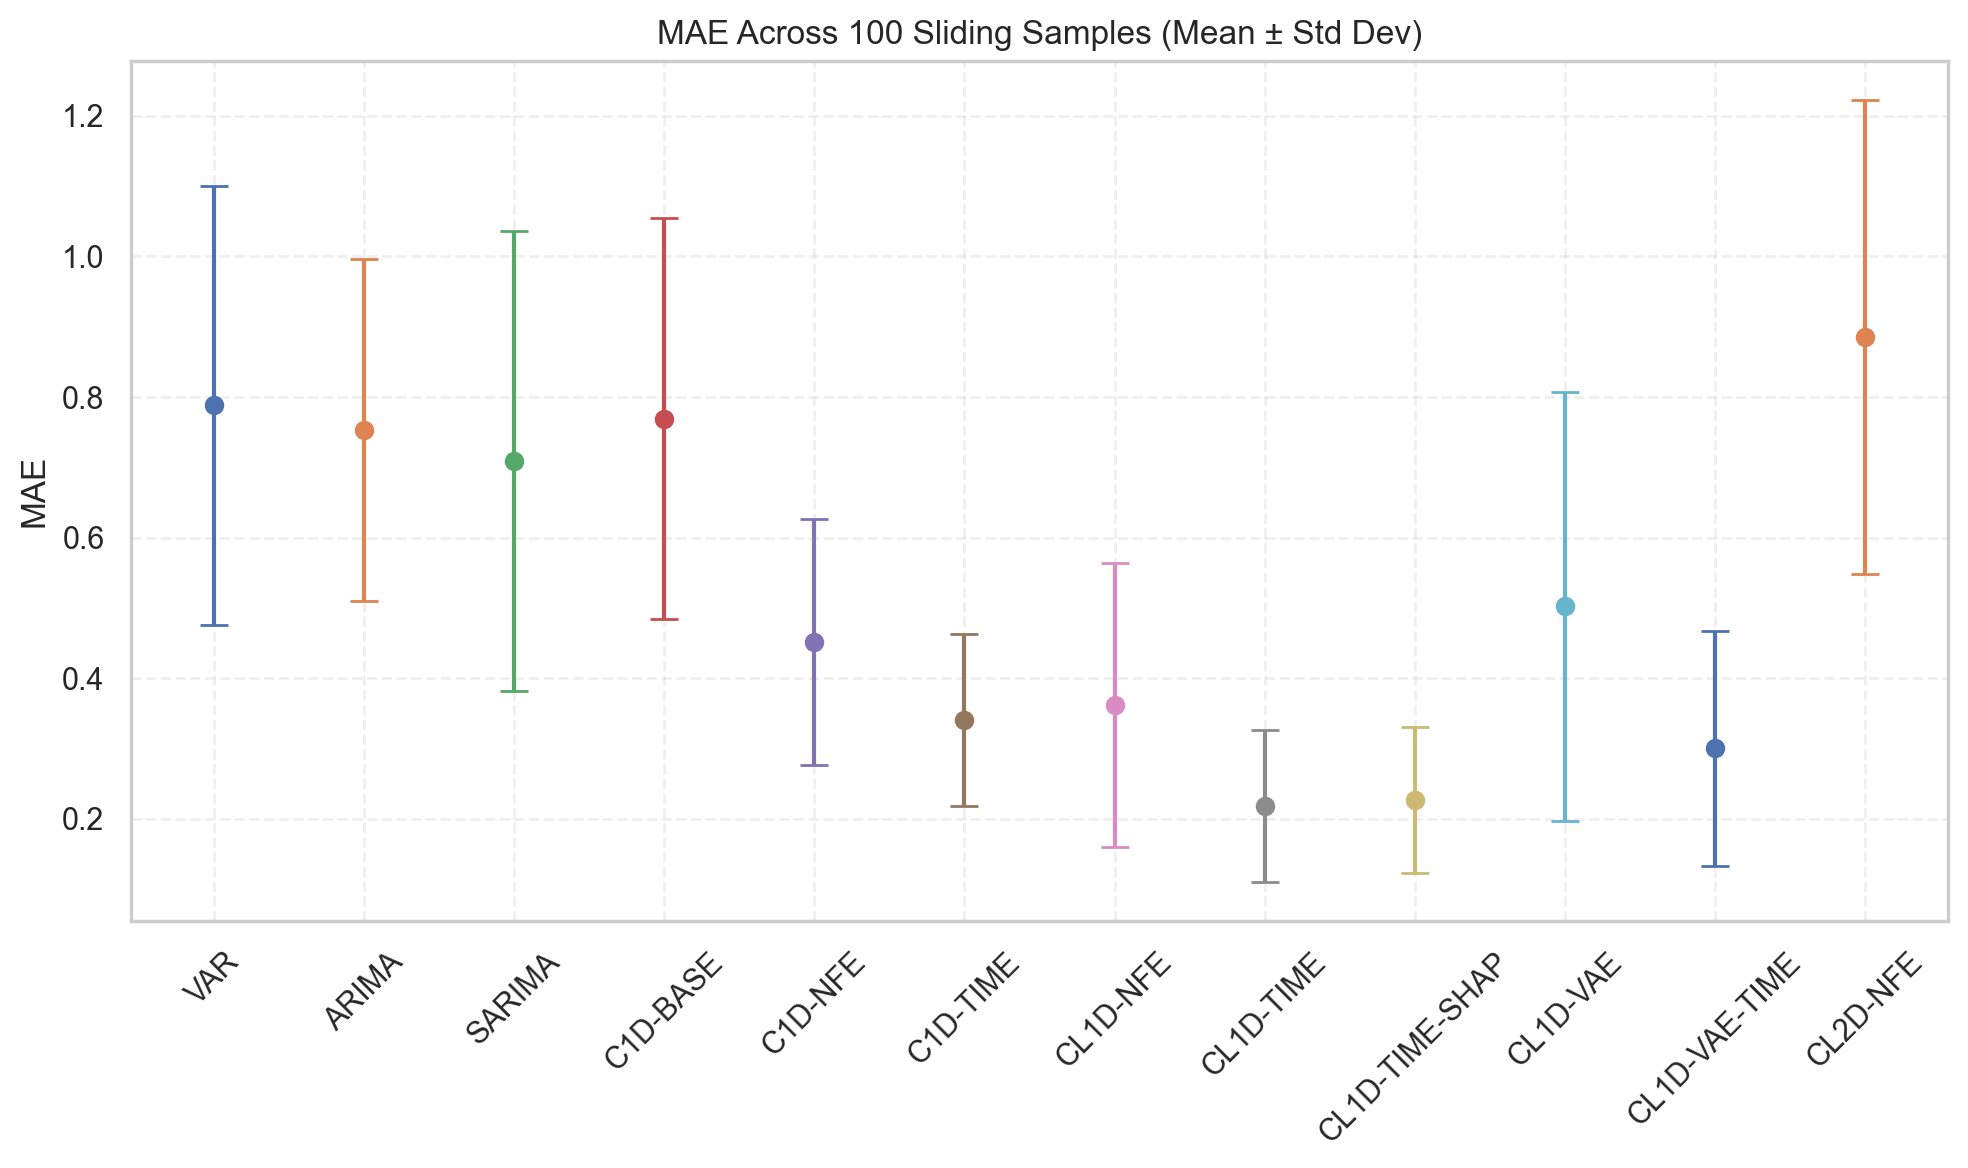

In [35]:
plot_metric_with_std(mae_df, "MAE")
# plot_metric_with_std(rmse_df, "RMSE")

# boxplot_metric_distribution(mae_df, "MAE")
# boxplot_metric_distribution(rmse_df, "RMSE")

In [36]:
# Melt the data for Seaborn
# Reset index to make 'Iteration' a column again
mae_df_r = mae_df.copy().reset_index()
rmse_df_r = rmse_df.copy().reset_index()
mae_melted = mae_df_r.melt(id_vars="Iteration", var_name="Model", value_name="MAE")
rmse_melted = rmse_df_r.melt(id_vars="Iteration", var_name="Model", value_name="RMSE")

# Compute mean MAE and RMSE per model
mean_mae = mae_df_r.drop(columns="Iteration", errors='ignore').mean()
mean_rmse = rmse_df_r.drop(columns="Iteration", errors='ignore').mean()


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/393883759.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=mae_melted, x="Iteration", y="MAE", hue="Model", ci=95)


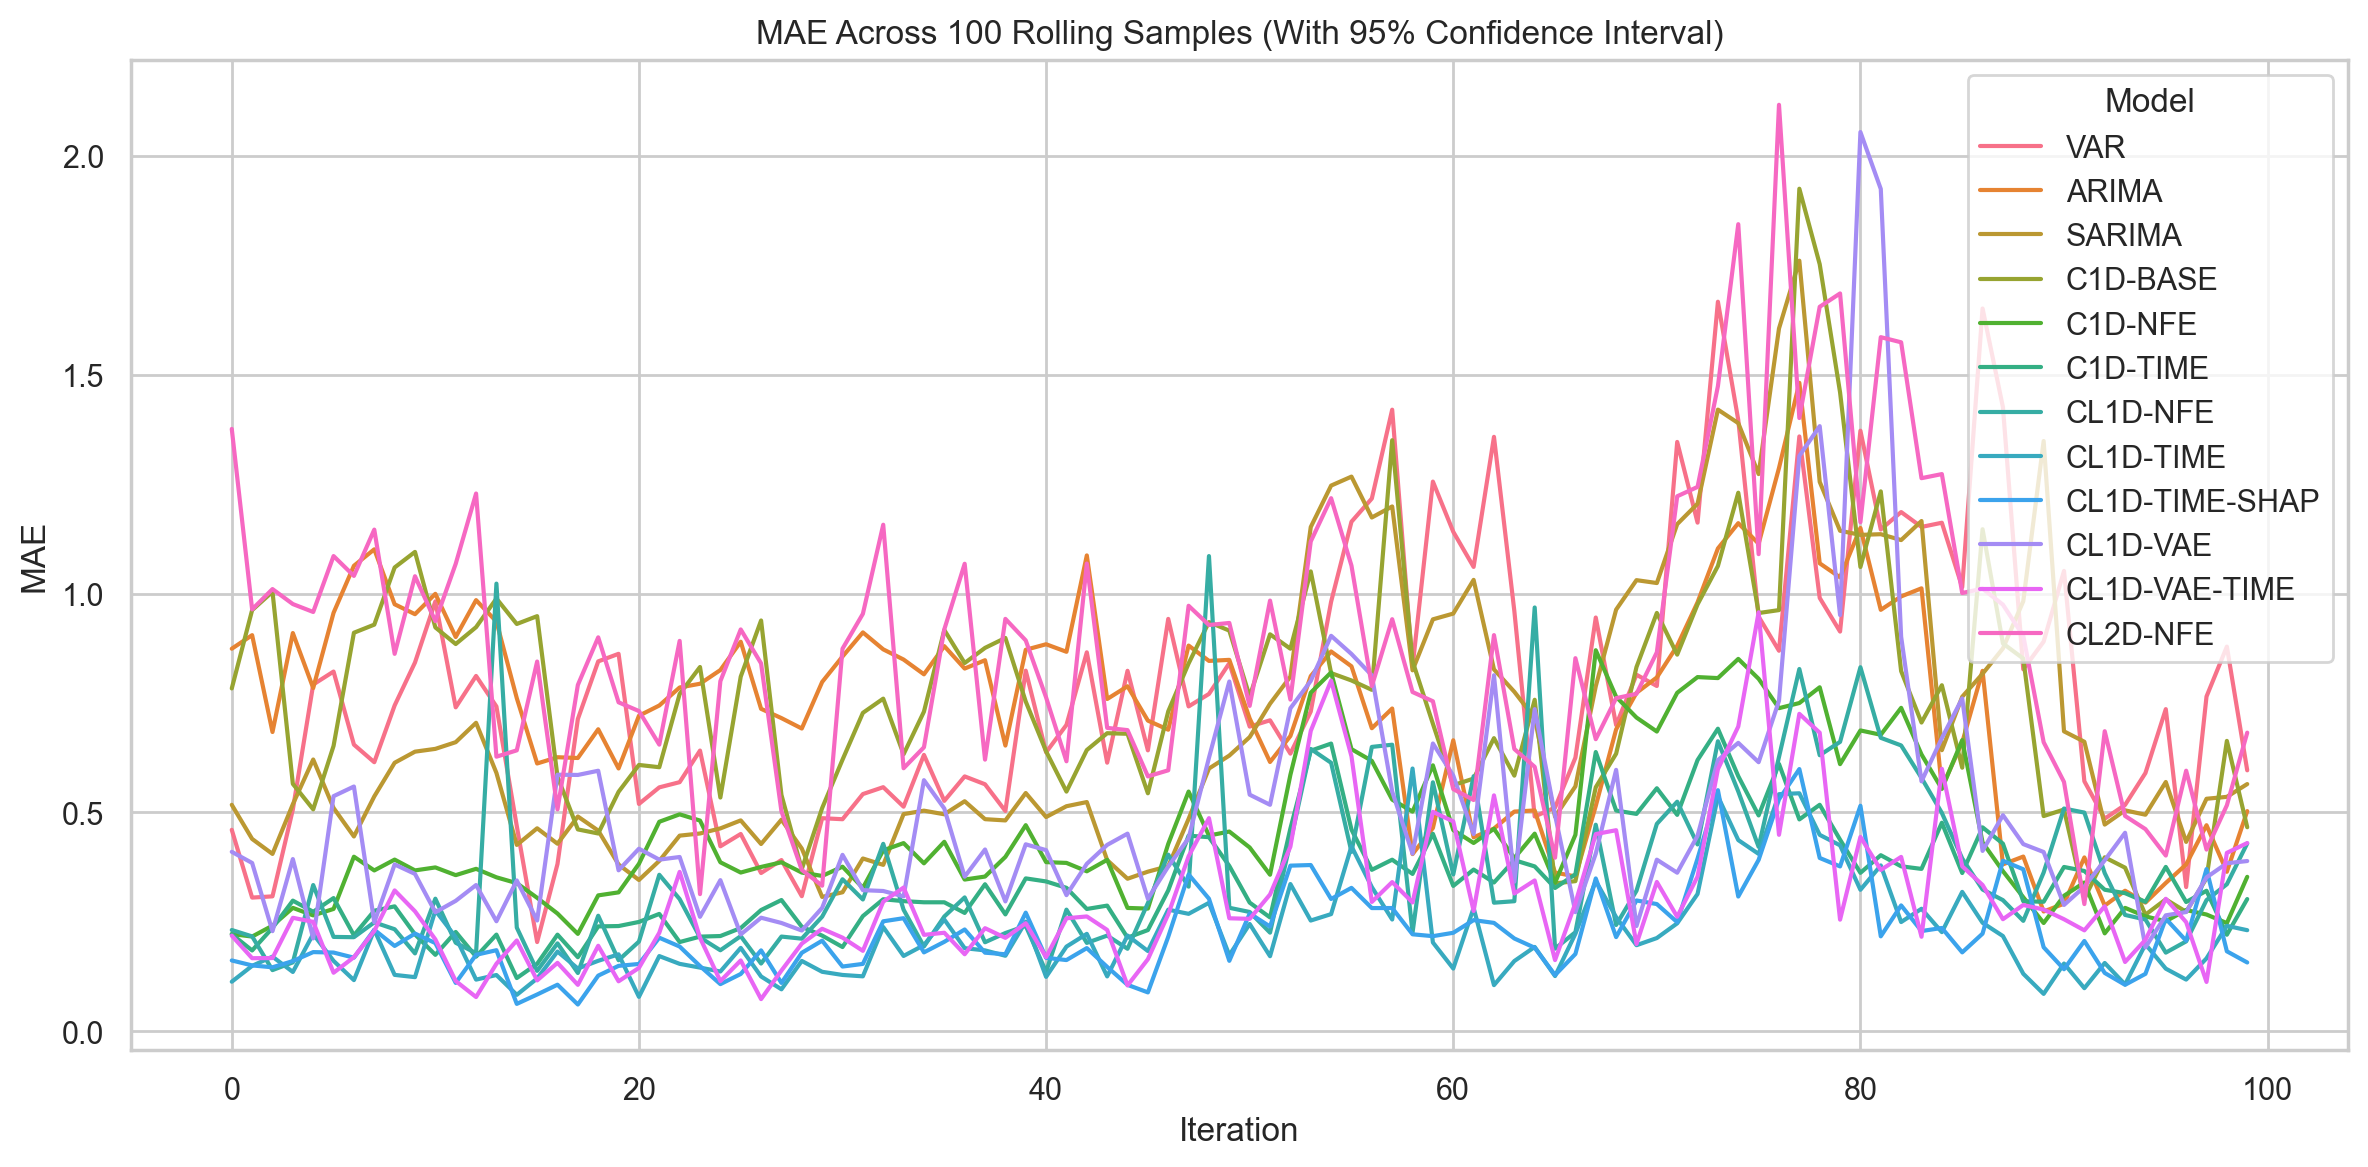

In [37]:

# Plot MAE
plt.figure(figsize=(12, 6))
sns.lineplot(data=mae_melted, x="Iteration", y="MAE", hue="Model", ci=95)
plt.title("MAE Across 100 Rolling Samples (With 95% Confidence Interval)")
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.grid(True)
plt.tight_layout()
plt.show()



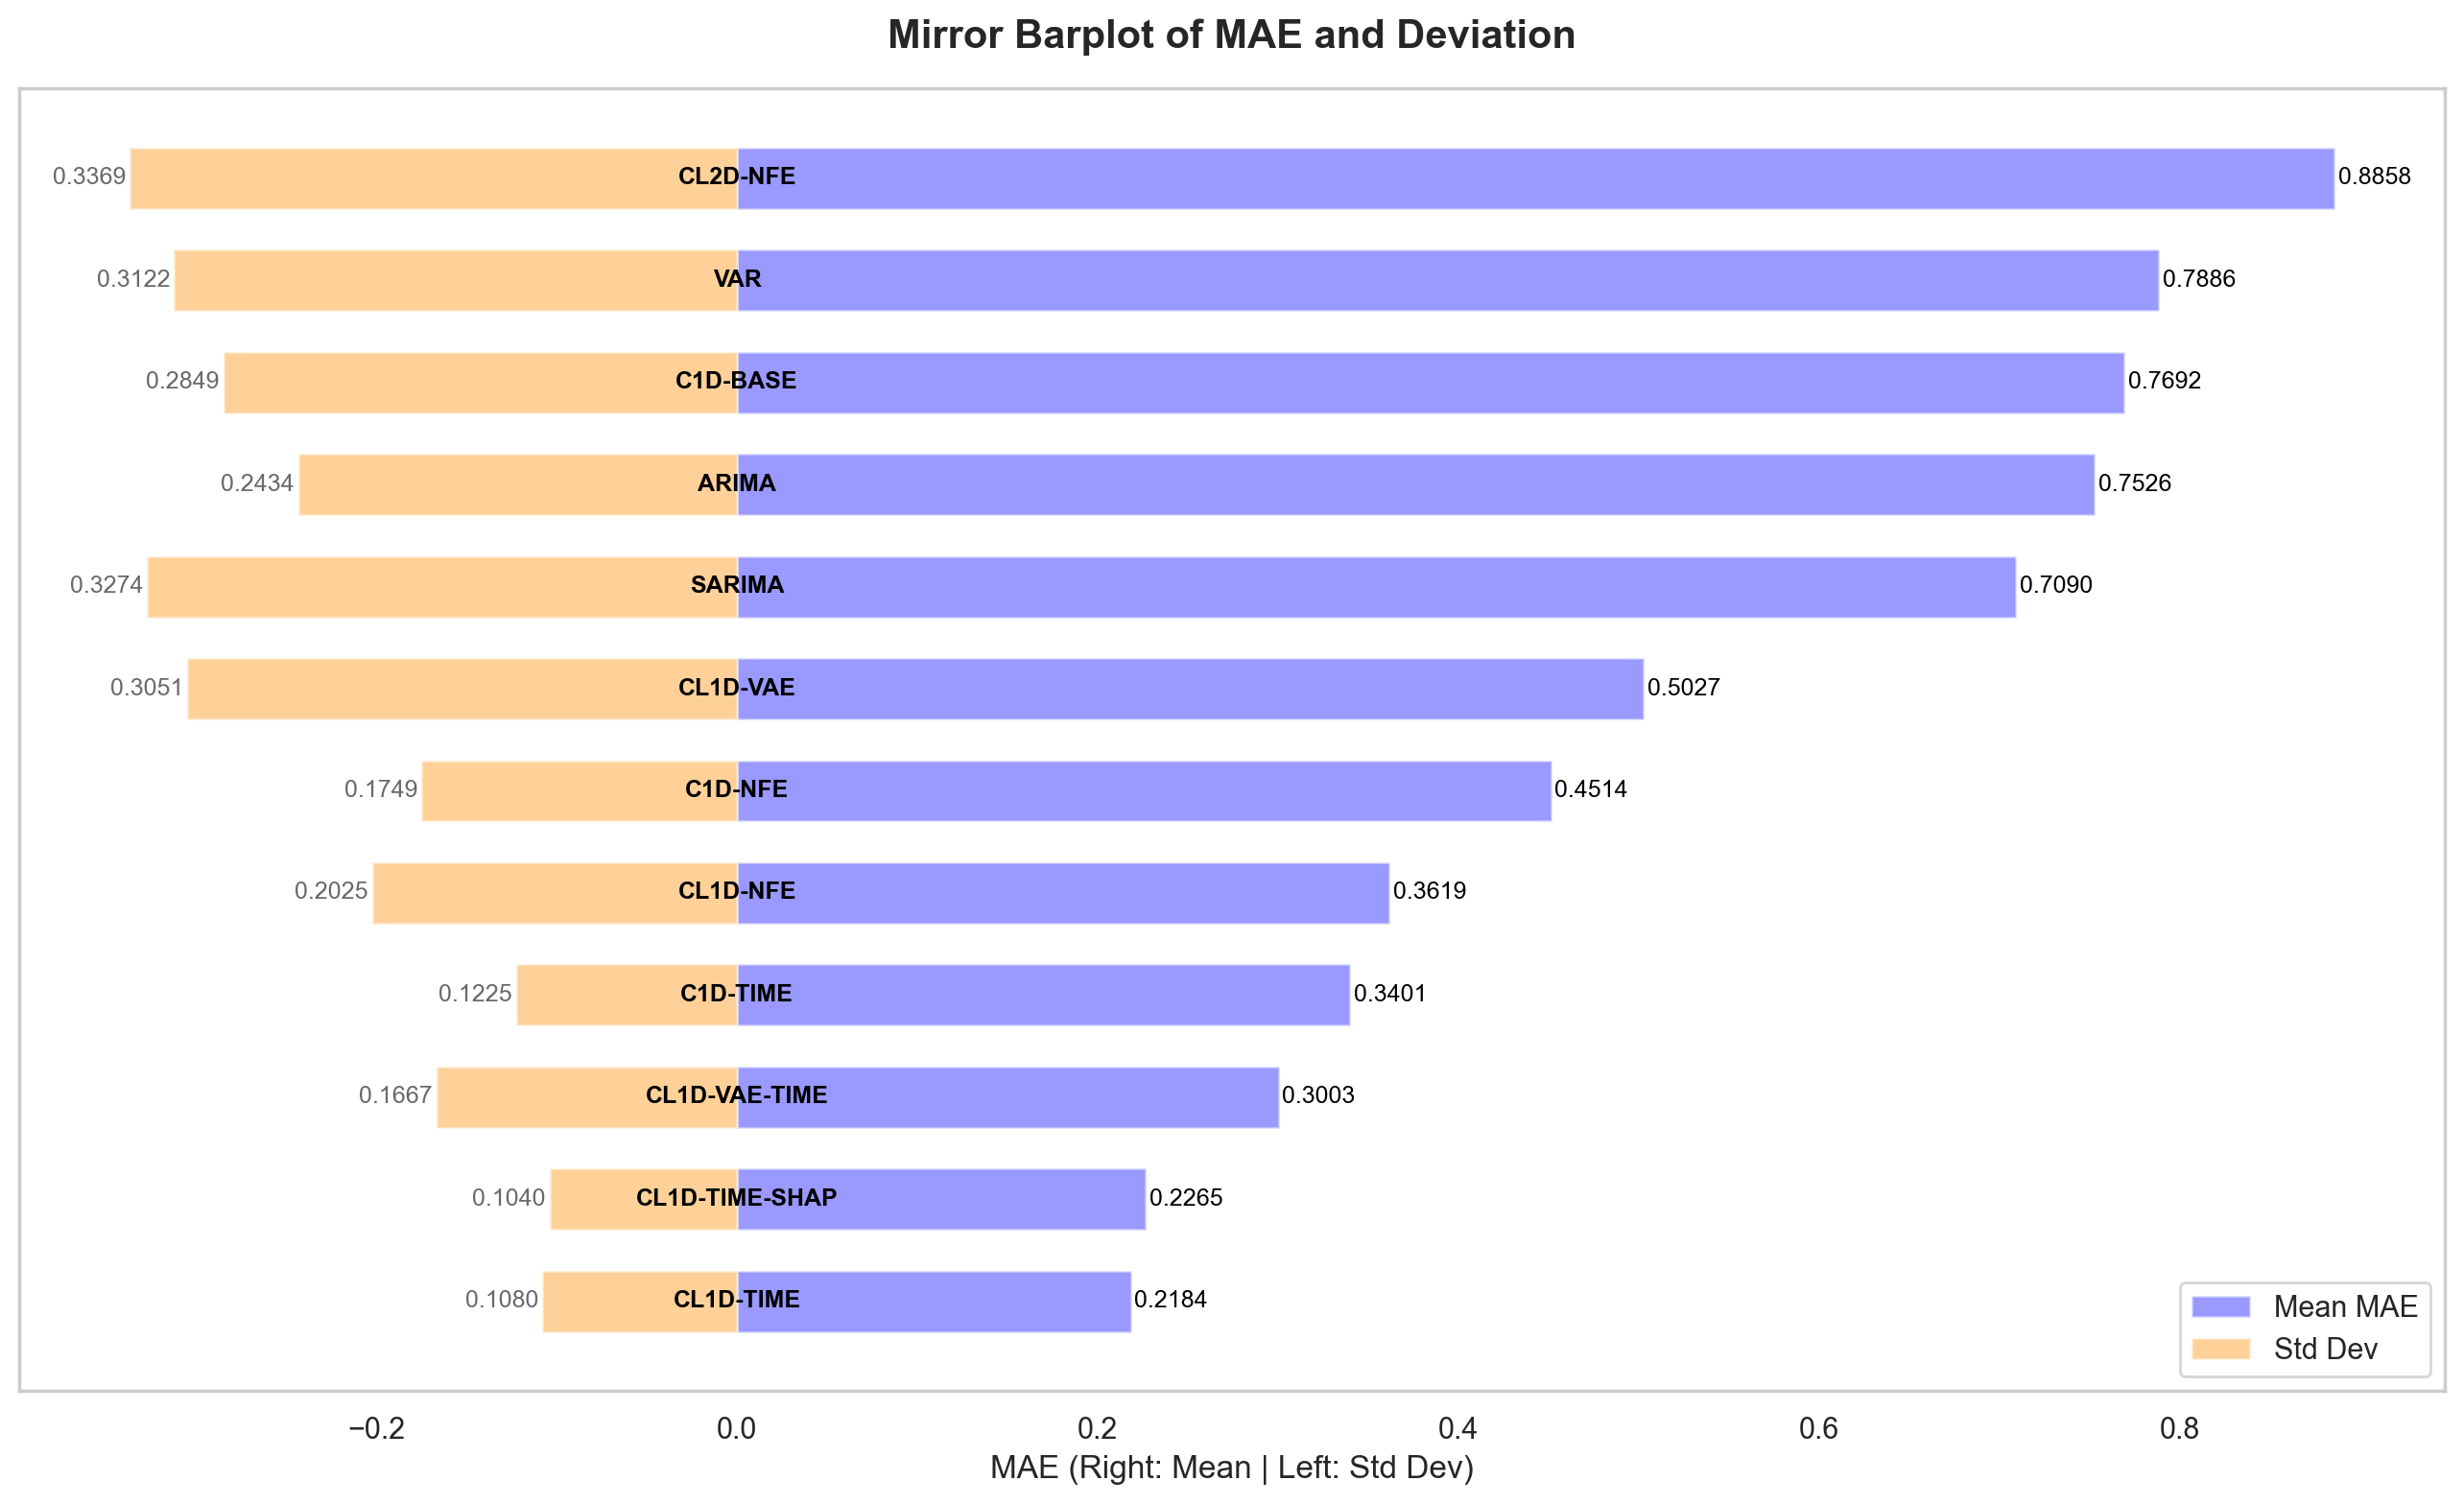

In [38]:
plot_mae_mirror_barplot(mae_df)


In [39]:


def plot_model_performance_panels(mae_df, models_to_plot=None, ci=95, title="MAE Across 100 Iterations (Per Model Highlighted)"):
    """
    Multi-panel line plot of model MAEs over iterations, highlighting one model per panel.

    Parameters:
    - mae_df: DataFrame with shape (iterations, models)
    - models_to_plot: List of model names to include (optional)
    - ci: Confidence interval shading for highlighted model (default: 95)
    - title: Title of the figure
    """
    # Reshape to long format
    melted_df = mae_df.reset_index(drop=True).reset_index().melt(id_vars="index", var_name="Model", value_name="MAE")
    melted_df = melted_df.rename(columns={"index": "Iteration"})

    all_models = melted_df['Model'].unique()
    models = [m for m in models_to_plot if m in all_models] if models_to_plot else all_models
    n_models = len(models)
    n_cols = 3
    n_rows = int(np.ceil(n_models / n_cols))

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, model in enumerate(models):
        ax = axes[i]

        # Plot all other models in gray
        for other in models:
            if other != model:
                sns.lineplot(
                    data=melted_df[melted_df['Model'] == other],
                    x="Iteration", y="MAE",
                    color='lightgray', alpha=0.4, linewidth=1,
                    ci=None, ax=ax
                )

        # Plot the highlighted model
        sns.lineplot(
            data=melted_df[melted_df['Model'] == model],
            x="Iteration", y="MAE",
            label=model.upper(),
            ax=ax, linewidth=2, ci=ci
        )

        ax.set_title(model.upper(), fontsize=10, weight='bold')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend().remove()

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=16, weight='bold')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



def plot_model_performance_panels_bands(mae_df, models_to_plot=None, ci=95, title="MAE Across 100 Iterations (Per Model Highlighted)"):

    # Ensure iteration index is numeric and 0-based for consistent plotting
    mae_df_processed = mae_df.copy().reset_index(drop=True)
    best_models_per_iteration = mae_df_processed.idxmin(axis=1)

    # Create a mapping from model name to a list of iterations where it was best
    best_iterations_map = {model_name: [] for model_name in mae_df_processed.columns}
    for iter_idx, best_model_name in best_models_per_iteration.items():
        best_iterations_map[best_model_name].append(iter_idx)

    # Prepare DataFrame for melting (for Seaborn plotting)
    melted_df = mae_df_processed.reset_index().rename(columns={"index": "Iteration"})
    melted_df = melted_df.melt(id_vars="Iteration", var_name="Model", value_name="MAE")

    all_models_in_data = mae_df_processed.columns.tolist() # Get all original model names
    models_to_display = [m for m in models_to_plot if m in all_models_in_data] if models_to_plot else all_models_in_data

    n_models = len(models_to_display)
    if n_models == 0:
        print("No models found to plot. Check 'models_to_plot' and 'mae_df' columns.")
        return

    n_cols = 3 # Number of columns in the subplot grid
    n_rows = int(np.ceil(n_models / n_cols))

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten() # Flatten the axes array for easy iteration

    # --- Plotting loop ---
    for i, model in enumerate(models_to_display):
        ax = axes[i]

        # Plot all other models in gray background
        for other_model in all_models_in_data: # Compare against ALL models in the original mae_df
            if other_model != model:
                sns.lineplot(
                    data=melted_df[melted_df['Model'] == other_model],
                    x="Iteration", y="MAE",
                    color='lightgray', alpha=0.4, linewidth=1,
                    ci=None, ax=ax # ci=None to remove confidence interval for background lines
                )

        # Plot the current highlighted model's line
        # Use the label parameter here; legend will be created manually later for the figure
        sns.lineplot(
            data=melted_df[melted_df['Model'] == model],
            x="Iteration", y="MAE",
            label=model, # Keep label for potential manual legend creation later
            ax=ax, linewidth=2, ci=ci
        )

        # Highlight periods where the current 'model' is the overall best
        best_periods_for_current_model = best_iterations_map.get(model, [])
        if best_periods_for_current_model:
            for iter_idx in best_periods_for_current_model:
                ax.axvspan(iter_idx - 0.5, iter_idx + 0.5, color='lightgreen', alpha=0.3, lw=0) # Use 'lightgreen' for best periods

        ax.set_title(model, fontsize=11, weight='bold') # Set subplot title to model name
        ax.set_xlabel("Iteration", fontsize=9)
        ax.set_ylabel("MAE", fontsize=9)
        ax.tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis labels if needed
        ax.tick_params(axis='y', labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend().remove() # Remove individual subplot legends to create a single figure legend

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # --- Create a single, unified legend for the entire figure ---
    # This involves getting handles and labels from the plotted lines and the highlight patch
    handles, labels = [], []

    # 1. Add legend entry for the "Best Performance" highlight
    best_performance_patch = plt.Rectangle((0, 0), 1, 1, fc="lightgreen", alpha=0.3, edgecolor='none')
    handles.append(best_performance_patch)
    labels.append("Best Performance (Overall)")

    # 2. Add legend entries for each model's line
    # Iterate through models_to_display to ensure correct order and colors for legend
    # Seaborn automatically assigns colors if not specified. We can retrieve them.
    # This assumes models_to_display are ordered similarly to the internal Seaborn palette.
    for model in models_to_display:
        # Find a line object for the model in the first subplot it was plotted
        line_objects = [line for line in axes[0].get_lines() if line.get_label() == model]
        if line_objects:
            handles.append(line_objects[0]) # Get the first line object for the model
            labels.append(model)
        else: # If model not in first subplot or not found, create a dummy
            dummy_line, = plt.plot([], [], label=model, color=sns.color_palette()[models_to_display.index(model) % len(sns.color_palette())])
            handles.append(dummy_line)
            labels.append(model)

    #
    # fig.legend(handles, labels, loc='lower center', ncol=max(1, len(models_to_display) + 1),
    #            fontsize=9, bbox_to_anchor=(0.5, -0.02)) # Adjust bbox_to_anchor to position legend outside plots


    fig.suptitle(title, fontsize=16, weight='bold')
    # Adjust rect to leave space for the suptitle and the bottom legend
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()




In [40]:
print(mae_df.columns.tolist())

['VAR', 'ARIMA', 'SARIMA', 'C1D-BASE', 'C1D-NFE', 'C1D-TIME', 'CL1D-NFE', 'CL1D-TIME', 'CL1D-TIME-SHAP', 'CL1D-VAE', 'CL1D-VAE-TIME', 'CL2D-NFE']


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/1780163060.py:97: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/1780163060.py:97: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/1780163060.py:97: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/1780163060.py:97: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/1780163060.py:97: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/82/hxq3jkp51d38wnvh074k_2vh

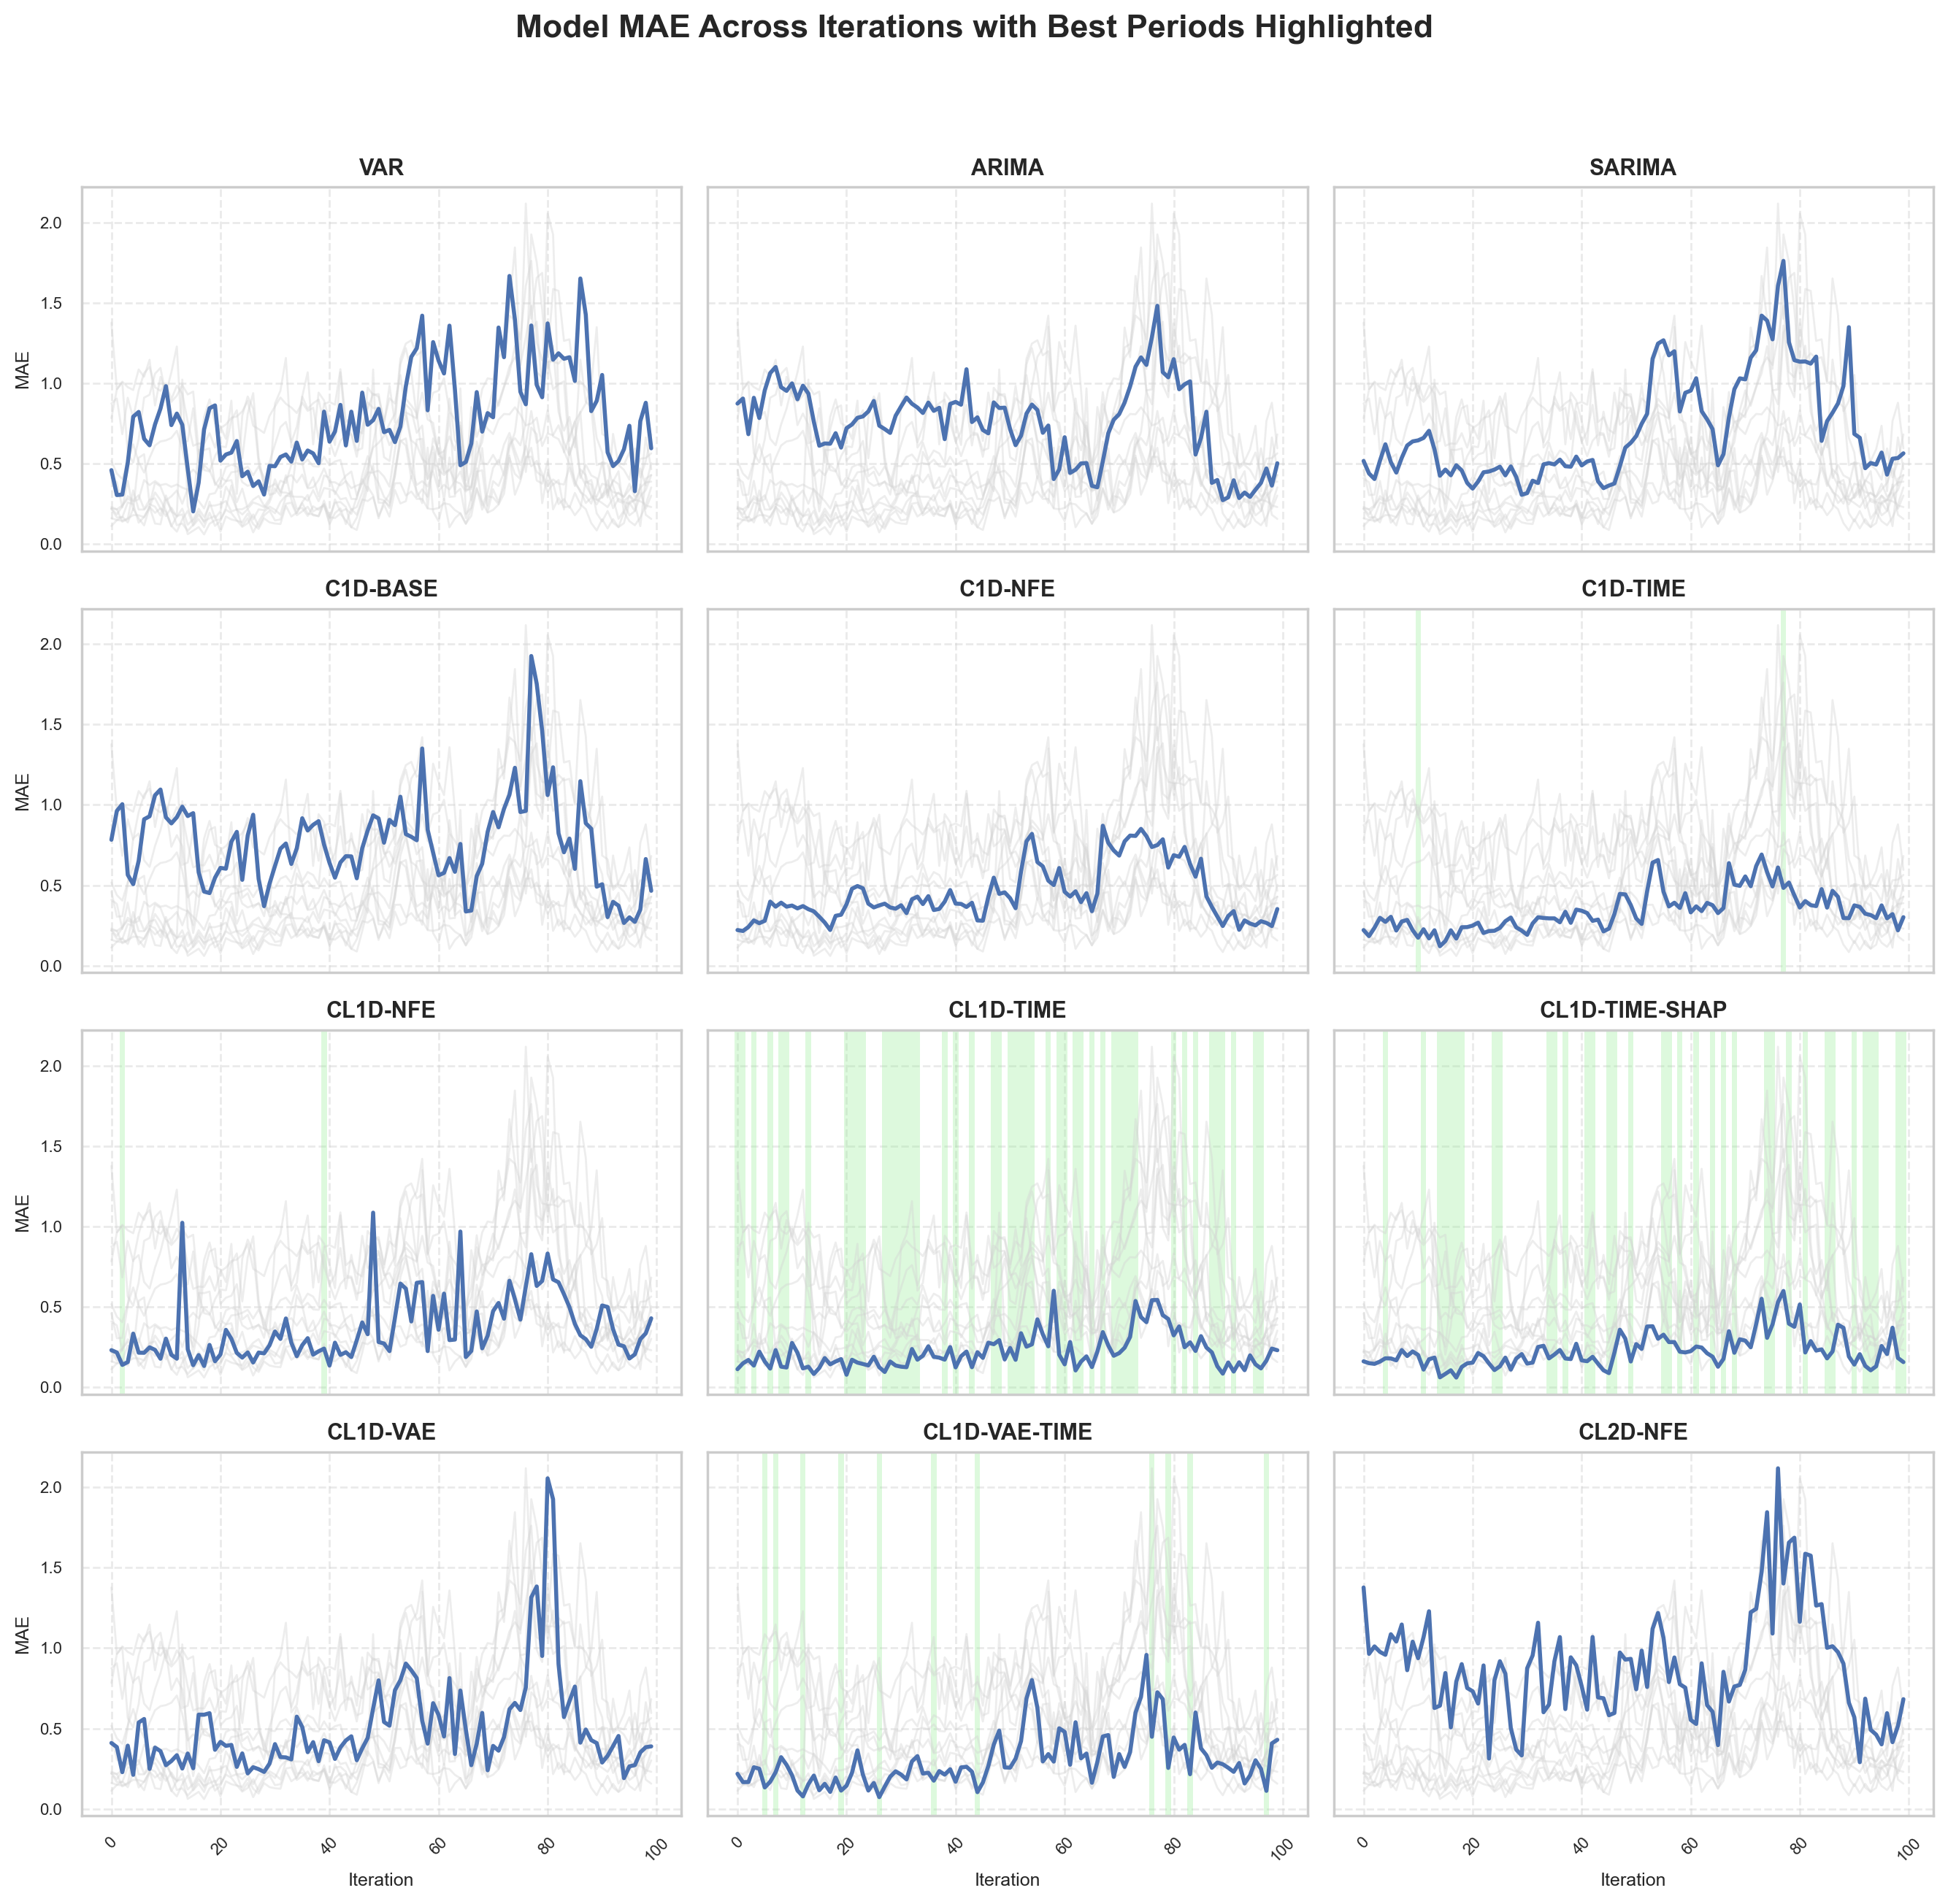

In [41]:
models_to_plot = ['C1D-BASE', 'C1D-NFE', 'C1D-TIME', 'CL1D-TIME']

# plot_model_performance_panels(mae_df, mae_df.columns.tolist(), ci=95)
# mae_df.set_index('Iteration', inplace=True)
# Plot performance panels for all models
plot_model_performance_panels_bands(mae_df, title="Model MAE Across Iterations with Best Periods Highlighted")

#  Plot performance panels for a specific subset of models
# plot_model_performance_panels(mae_df_example, models_to_plot=['VAR', 'CNN', 'LSTM'],
#                               title="Selected Model MAE Across Iterations with Best Periods Highlighted")



In [42]:


def plot_mae_with_highlight(mae_df, highlight_models=None, ci=95, title="MAE Across 100 Rolling Samples (With 95% CI)"):
    """
    Plot MAE over iterations with optional highlighting of selected models.

    Parameters:
    - mae_df: DataFrame with shape (iterations, models)
    - highlight_models: List of model names to highlight
    - ci: Confidence interval (default 95)
    - title: Title of the plot
    """
    # Melt the DataFrame to long format
    mae_melted = mae_df.reset_index(drop=True).reset_index().melt(id_vars="index", var_name="Model", value_name="MAE")
    mae_melted = mae_melted.rename(columns={"index": "Iteration"})

    highlight_models = [m.upper() for m in highlight_models] if highlight_models else []

    plt.figure(figsize=(14, 7))

    # Plot all models in gray
    for model in mae_melted['Model'].unique():
        data = mae_melted[mae_melted['Model'] == model]
        if model.upper() not in highlight_models:
            sns.lineplot(data=data, x="Iteration", y="MAE", label=model, color='lightgray', linewidth=1, alpha=0.6, ci=None)

    # Plot highlighted models in color
    palette = sns.color_palette("tab10", len(highlight_models))
    for i, model in enumerate(highlight_models):
        data = mae_melted[mae_melted['Model'].str.upper() == model]
        sns.lineplot(data=data, x="Iteration", y="MAE", label=model, linewidth=2.2, ci=ci, color=palette[i])

    plt.title(title, fontsize=16)
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("MAE", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Model", fontsize=10)
    plt.tight_layout()
    plt.show()


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/3709107202.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x="Iteration", y="MAE", label=model, color='lightgray', linewidth=1, alpha=0.6, ci=None)
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/3709107202.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x="Iteration", y="MAE", label=model, color='lightgray', linewidth=1, alpha=0.6, ci=None)
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/3709107202.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x="Iteration", y="MAE", label=model, color='lightgray', linewidth=1, alpha=0.6, ci=None)
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/3709107202.py:23: FutureWarning: 

The `ci` parameter is depre

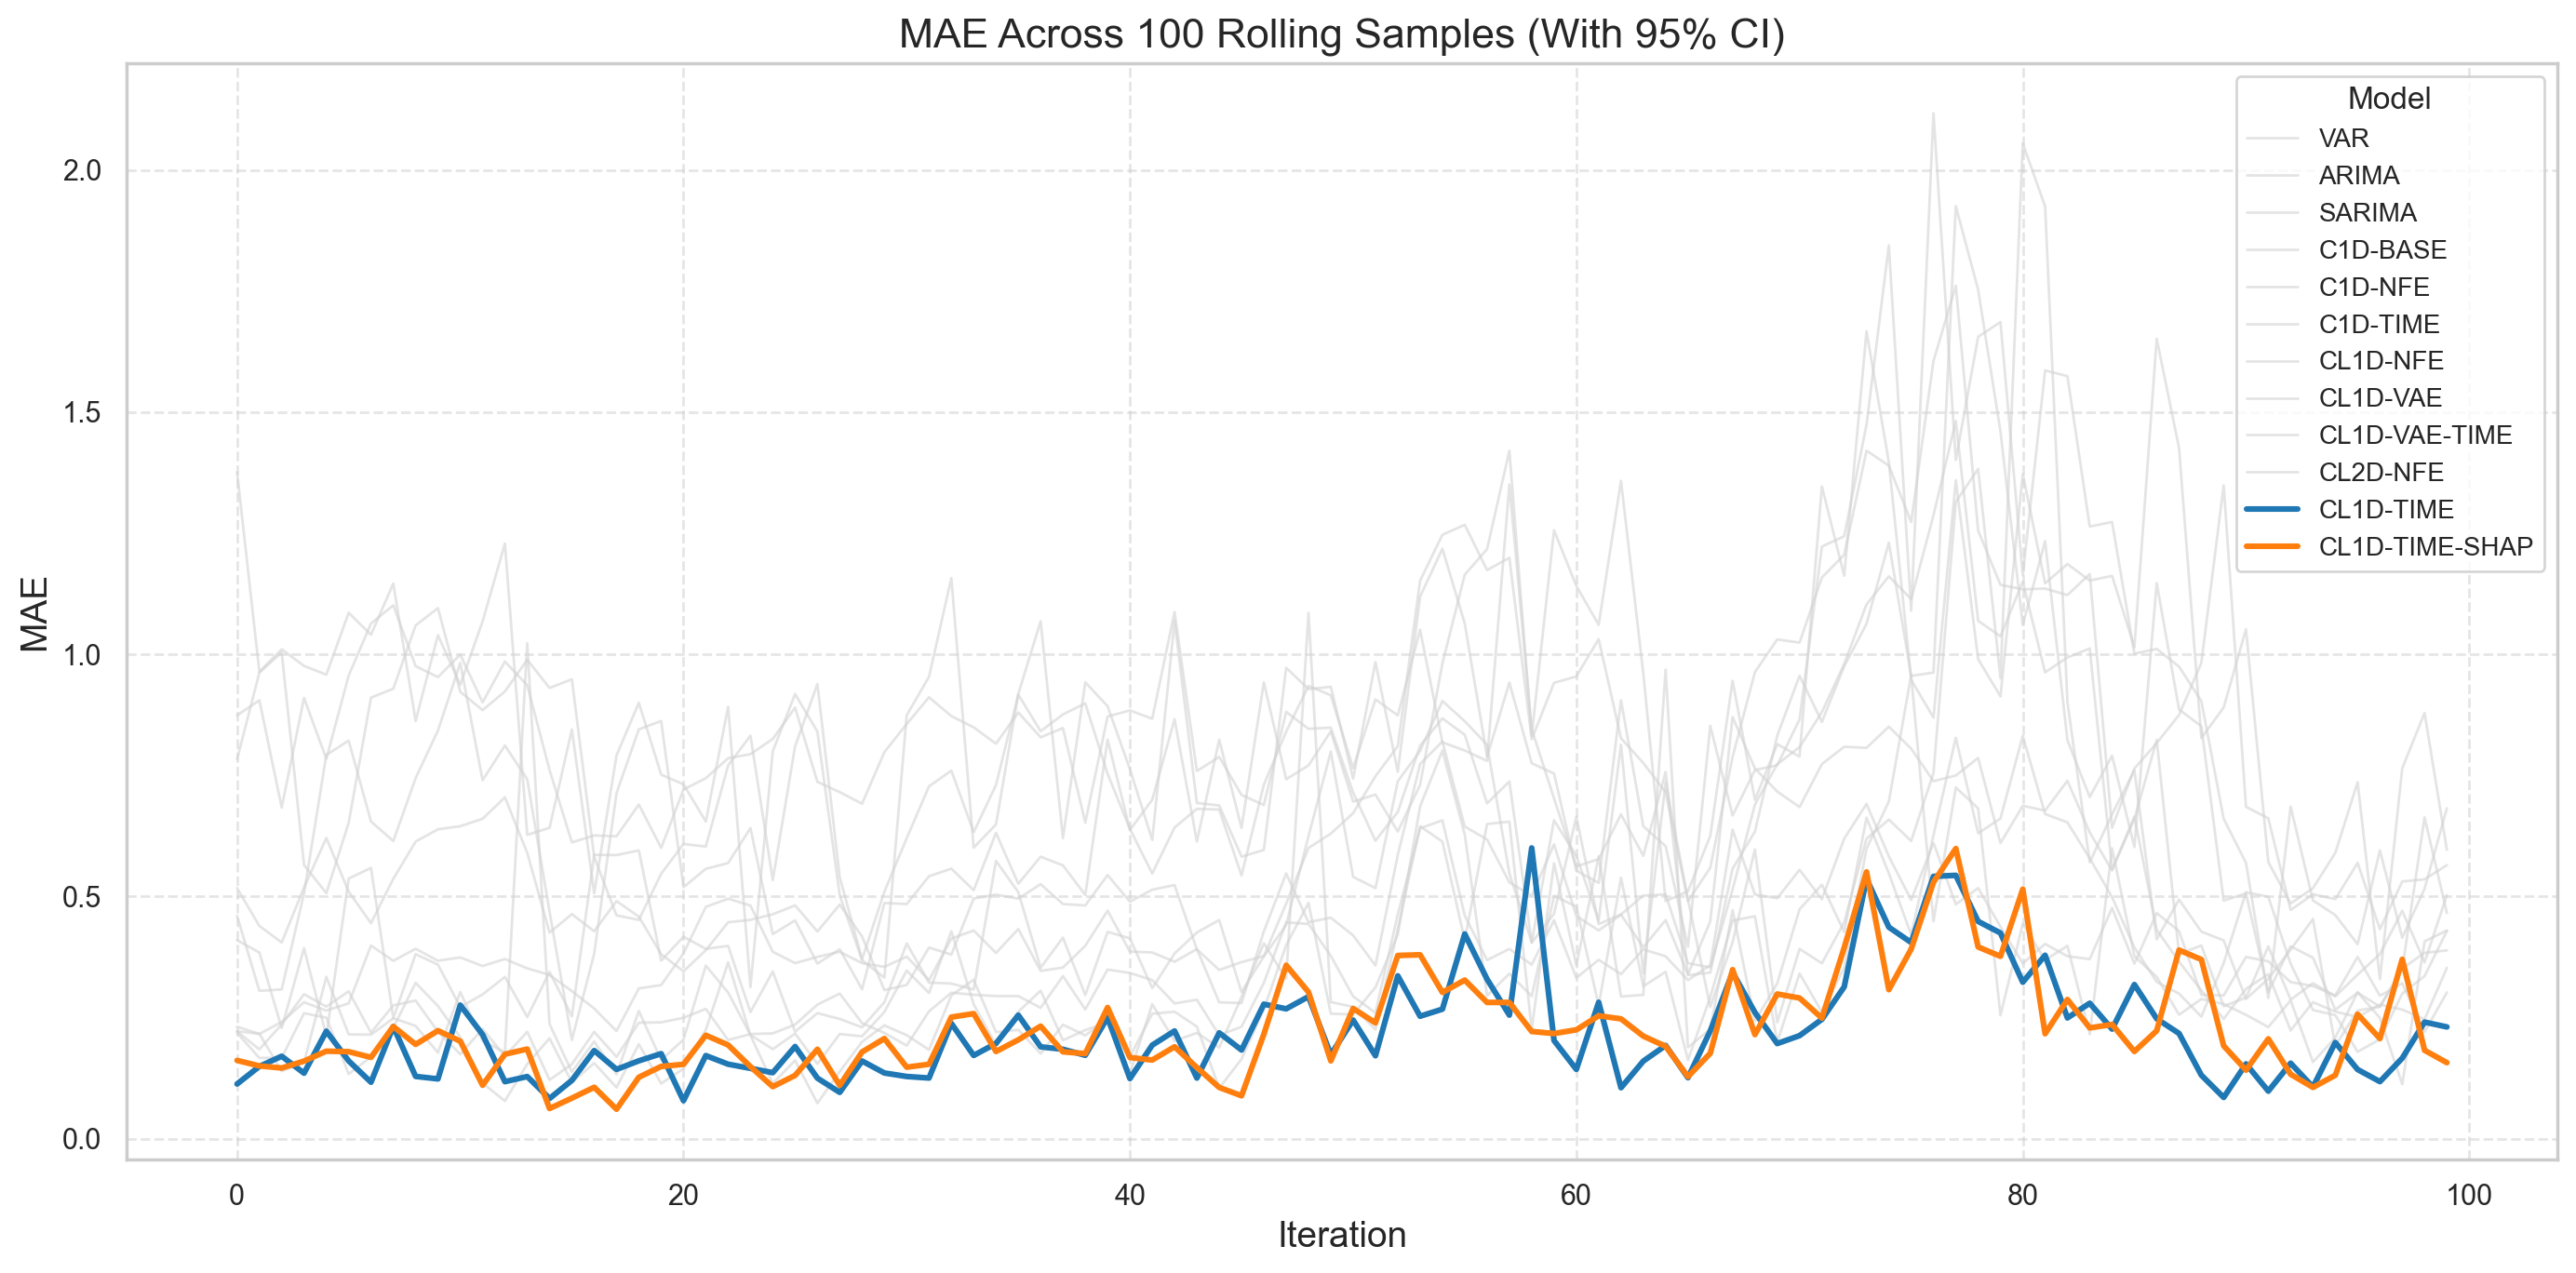

In [62]:
highlight = ['CL1D-TIME', 'CL1D-TIME-SHAP']
plot_mae_with_highlight(mae_df, highlight_models=highlight)


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/2443461211.py:105: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/2443461211.py:105: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/2443461211.py:105: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/2443461211.py:105: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904

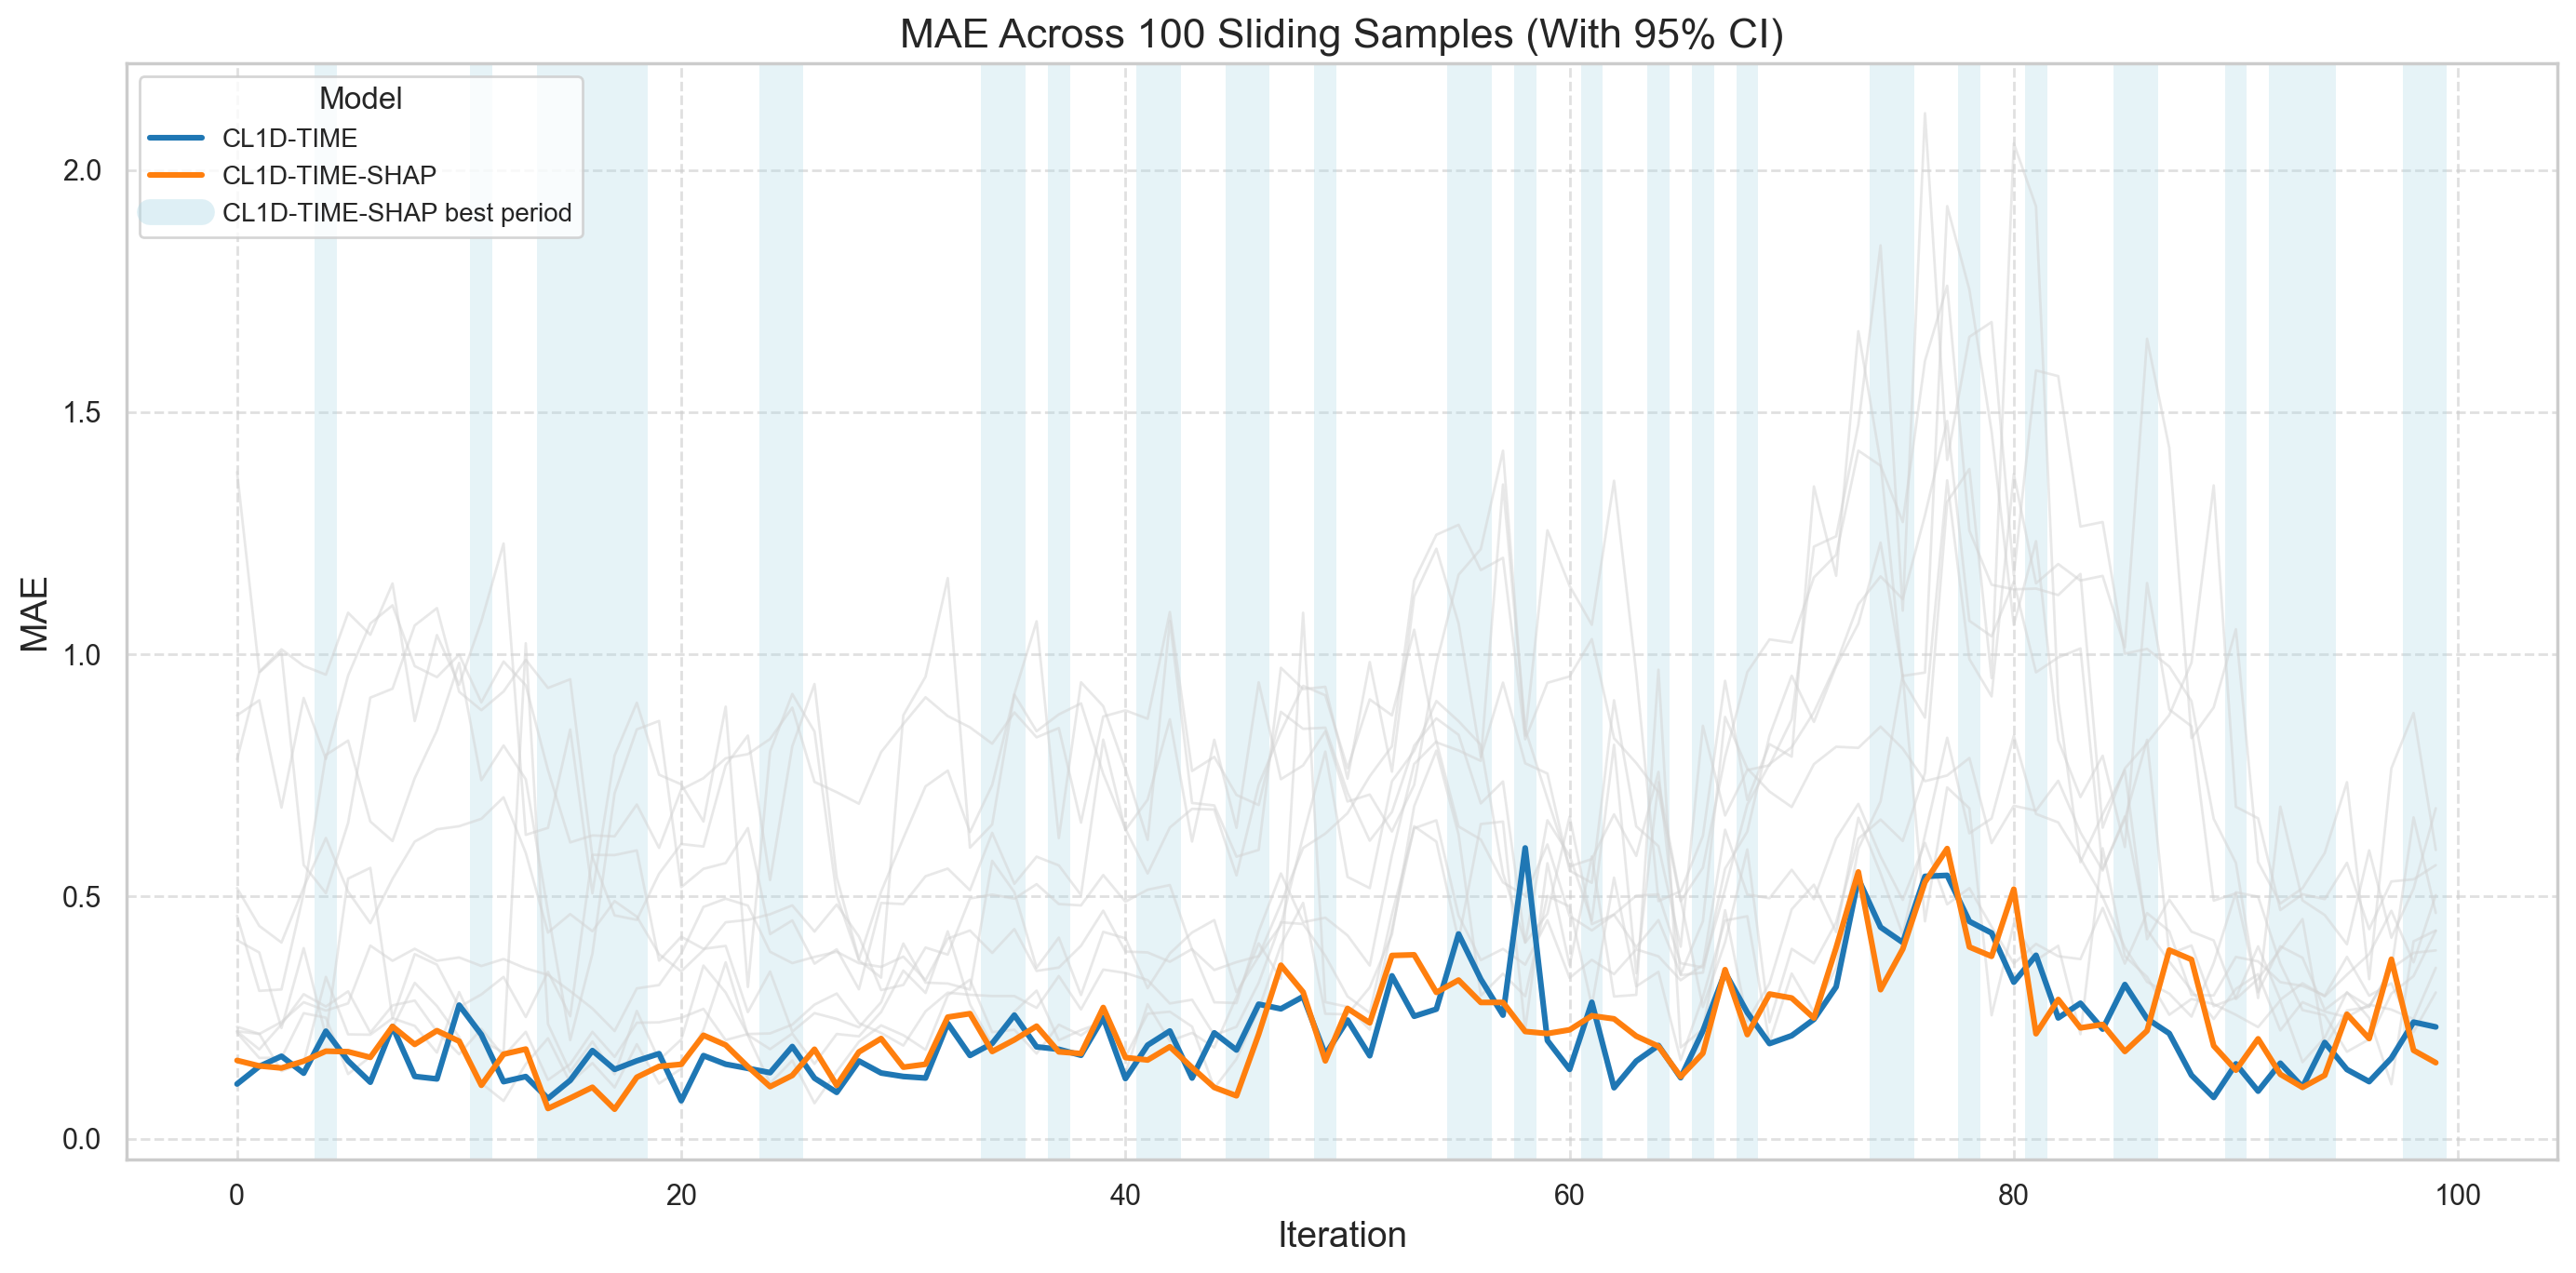

In [63]:
# Highlight two models, and also mark periods where VAR was the best
best_iterations = plot_mae_with_highlight_and_bands(mae_df,
                                         highlight_models=highlight,
                                         mark_best_model='CL1D-TIME-SHAP')


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/2443461211.py:188: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/2443461211.py:188: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/2443461211.py:188: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904/2443461211.py:188: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_11904

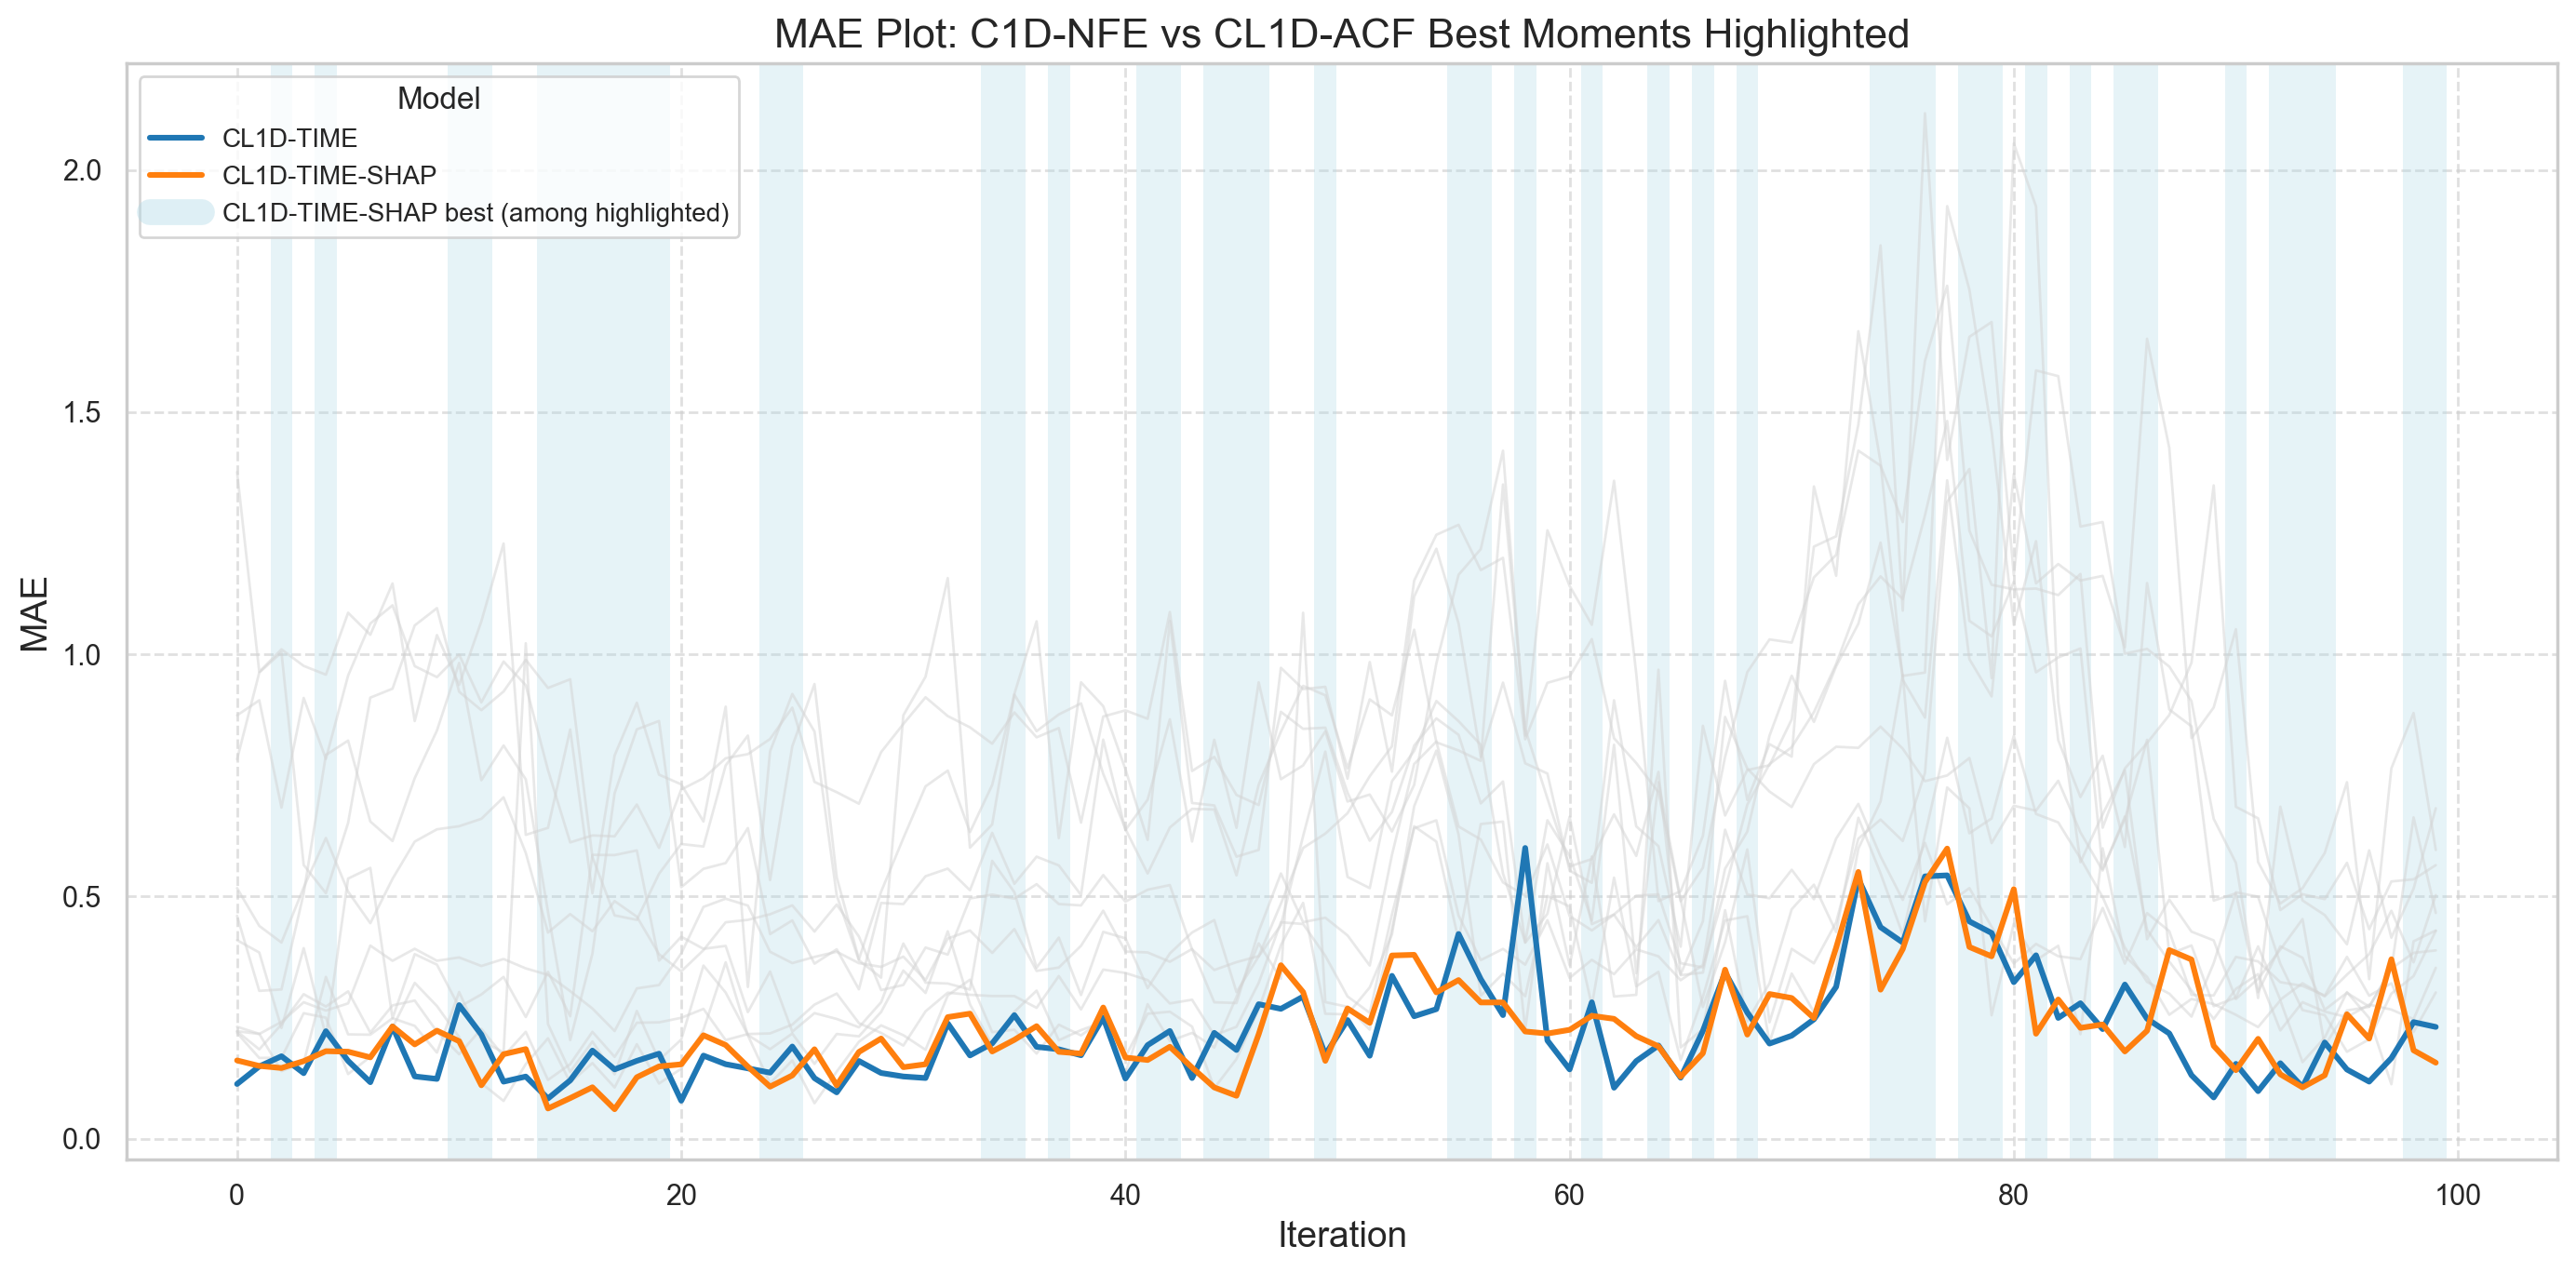

[2,
 4,
 10,
 11,
 14,
 15,
 16,
 17,
 18,
 19,
 24,
 25,
 34,
 35,
 37,
 41,
 42,
 44,
 45,
 46,
 49,
 55,
 56,
 58,
 61,
 64,
 66,
 68,
 74,
 75,
 76,
 78,
 79,
 81,
 83,
 85,
 86,
 90,
 92,
 93,
 94,
 98,
 99]

In [64]:



plot_mae_with_highlight_bands_btw(
    mae_df,
    highlight_models=highlight, # Highlight all dummy models
    mark_best_model='CL1D-TIME-SHAP',         # Check where CNN is best among all dummy models
    title="MAE Plot: C1D-NFE vs CL1D-ACF Best Moments Highlighted"
)



In [65]:

def calculate_average_forecast_steps(forecast_df, model_prefixes, test_size=12):
    results = {}
    for model_prefix in model_prefixes:
        step_cols = [f"{model_prefix}_step{j+1}" for j in range(test_size)]

        if all(col in forecast_df.columns for col in step_cols):
            # Extract data for the current model's steps
            model_data = forecast_df[step_cols].values # Shape: (num_iterations, test_size)
            # Calculate the mean across the iterations (axis=0) for each step
            mean_across_iterations = np.mean(model_data, axis=0)
            # Store the results
            results[model_prefix] = mean_across_iterations
        else:
            print(f"[Warning] Skipping model '{model_prefix}': Not all forecast step columns found.")

    if not results:
        print("No valid model forecast data found in the DataFrame.")
        return None

    # Convert the dictionary of results to a DataFrame
    # Keys will become index (model names), values will be rows (step averages)
    # Transpose to get models on rows and steps on columns
    average_forecast_df = pd.DataFrame(results).T

    # Rename columns to 'step1', 'step2', etc. for clarity
    average_forecast_df.columns = [f"step{j+1}" for j in range(test_size)]

    return average_forecast_df




In [70]:
# Calculate and print the average forecast for each model and step
average_steps_df = calculate_average_forecast_steps(
    forecast_df,
    mae_df.columns.tolist(),
    test_size=12 # Use the correct test_size for your data
)


In [71]:
average_steps_df['Overall Mean'] = average_steps_df.mean(axis=1)
styled_df = average_steps_df.style.highlight_min(axis=0, color='lightgreen')
display(styled_df)


In [72]:
# Starting date of first sample
start_date_first_sample = pd.Timestamp("1999-04-01")
window_length = 209  # 175 months per sample
num_iterations = 100

# Generate all iteration date ranges
iteration_ranges = {}

for i in range(1, num_iterations + 1):
    start = start_date_first_sample + pd.DateOffset(months=i - 1)
    end = start + pd.DateOffset(months=window_length - 1)
    iteration_ranges[i] = (start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"))

# Example: Print for iteration 53 to 63 (Base CNN winning region)
for i in best_iterations:
    print(f"Iteration {i}: {iteration_ranges[i][0]} to {iteration_ranges[i][1]}")

Iteration 4: 1999-07-01 to 2016-11-01
Iteration 11: 2000-02-01 to 2017-06-01
Iteration 14: 2000-05-01 to 2017-09-01
Iteration 15: 2000-06-01 to 2017-10-01
Iteration 16: 2000-07-01 to 2017-11-01
Iteration 17: 2000-08-01 to 2017-12-01
Iteration 18: 2000-09-01 to 2018-01-01
Iteration 24: 2001-03-01 to 2018-07-01
Iteration 25: 2001-04-01 to 2018-08-01
Iteration 34: 2002-01-01 to 2019-05-01
Iteration 35: 2002-02-01 to 2019-06-01
Iteration 37: 2002-04-01 to 2019-08-01
Iteration 41: 2002-08-01 to 2019-12-01
Iteration 42: 2002-09-01 to 2020-01-01
Iteration 45: 2002-12-01 to 2020-04-01
Iteration 46: 2003-01-01 to 2020-05-01
Iteration 49: 2003-04-01 to 2020-08-01
Iteration 55: 2003-10-01 to 2021-02-01
Iteration 56: 2003-11-01 to 2021-03-01
Iteration 58: 2004-01-01 to 2021-05-01
Iteration 61: 2004-04-01 to 2021-08-01
Iteration 64: 2004-07-01 to 2021-11-01
Iteration 66: 2004-09-01 to 2022-01-01
Iteration 68: 2004-11-01 to 2022-03-01
Iteration 74: 2005-05-01 to 2022-09-01
Iteration 75: 2005-06-01 t

In [73]:
# Calculate the average MAE for each model
average_mae_per_model = mae_melted.groupby('Model')['MAE'].mean()

# Sort the models by their average MAE in ascending order (lower MAE is better)
ranked_models = average_mae_per_model.sort_values(ascending=True)

# Identify the overall best model
overall_best_model = ranked_models.index[0]
min_avg_mae = ranked_models.iloc[0]

print("--- Overall Model Performance (Average MAE) ---")
print(ranked_models.to_string()) # .to_string() for better multi-line printing

print(f"\nConclusion: The overall best model is '{overall_best_model}' with an average MAE of {min_avg_mae:.4f}.")


--- Overall Model Performance (Average MAE) ---
Model
CL1D-TIME         0.218416
CL1D-TIME-SHAP    0.226548
CL1D-VAE-TIME     0.300283
C1D-TIME          0.340140
CL1D-NFE          0.361934
C1D-NFE           0.451445
CL1D-VAE          0.502725
SARIMA            0.709041
ARIMA             0.752617
C1D-BASE          0.769227
VAR               0.788585
CL2D-NFE          0.885799

Conclusion: The overall best model is 'CL1D-TIME' with an average MAE of 0.2184.


In [74]:

def test_mae_normality(mae_df, alpha=0.05):
    """
    Tests whether MAE values per model are normally distributed using Shapiro-Wilk test.

    Parameters:
    - mae_df: DataFrame with each model as a column and iterations as rows
    - alpha: Significance level (default = 0.05)

    Returns:
    - DataFrame with p-values and normality conclusion for each model
    """
    results = []

    for model in mae_df.columns:
        stat, p = shapiro(mae_df[model])
        results.append({
            'Model': model,
            'Shapiro-Wilk p-value': p,
            'Normally Distributed': p > alpha
        })

    return pd.DataFrame(results).sort_values(by='Shapiro-Wilk p-value')


In [75]:
normality_results = test_mae_normality(mae_df)
print(normality_results)


             Model  Shapiro-Wilk p-value  Normally Distributed
9         CL1D-VAE          1.678198e-12                 False
6         CL1D-NFE          8.803537e-09                 False
7        CL1D-TIME          4.650668e-08                 False
2           SARIMA          7.986678e-08                 False
10   CL1D-VAE-TIME          8.311576e-08                 False
4          C1D-NFE          7.104462e-07                 False
8   CL1D-TIME-SHAP          1.495416e-06                 False
3         C1D-BASE          1.080229e-04                 False
5         C1D-TIME          1.143446e-04                 False
11        CL2D-NFE          9.732731e-04                 False
0              VAR          3.463838e-03                 False
1            ARIMA          5.555720e-02                  True


Since majority of the models MAES are not normally distributed, we use a non-parametric test

In [76]:

# --- Step 1: Friedman Test (global comparison) ---
stat, p = friedmanchisquare(*[mae_df[col] for col in mae_df.columns])
print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.4e}")
if p < 0.05:
    print("→ Significant differences between models. Proceeding to post-hoc tests.")
else:
    print("→ No significant differences between models.")


Friedman test statistic: 837.9000, p-value: 1.3737e-172
→ Significant differences between models. Proceeding to post-hoc tests.


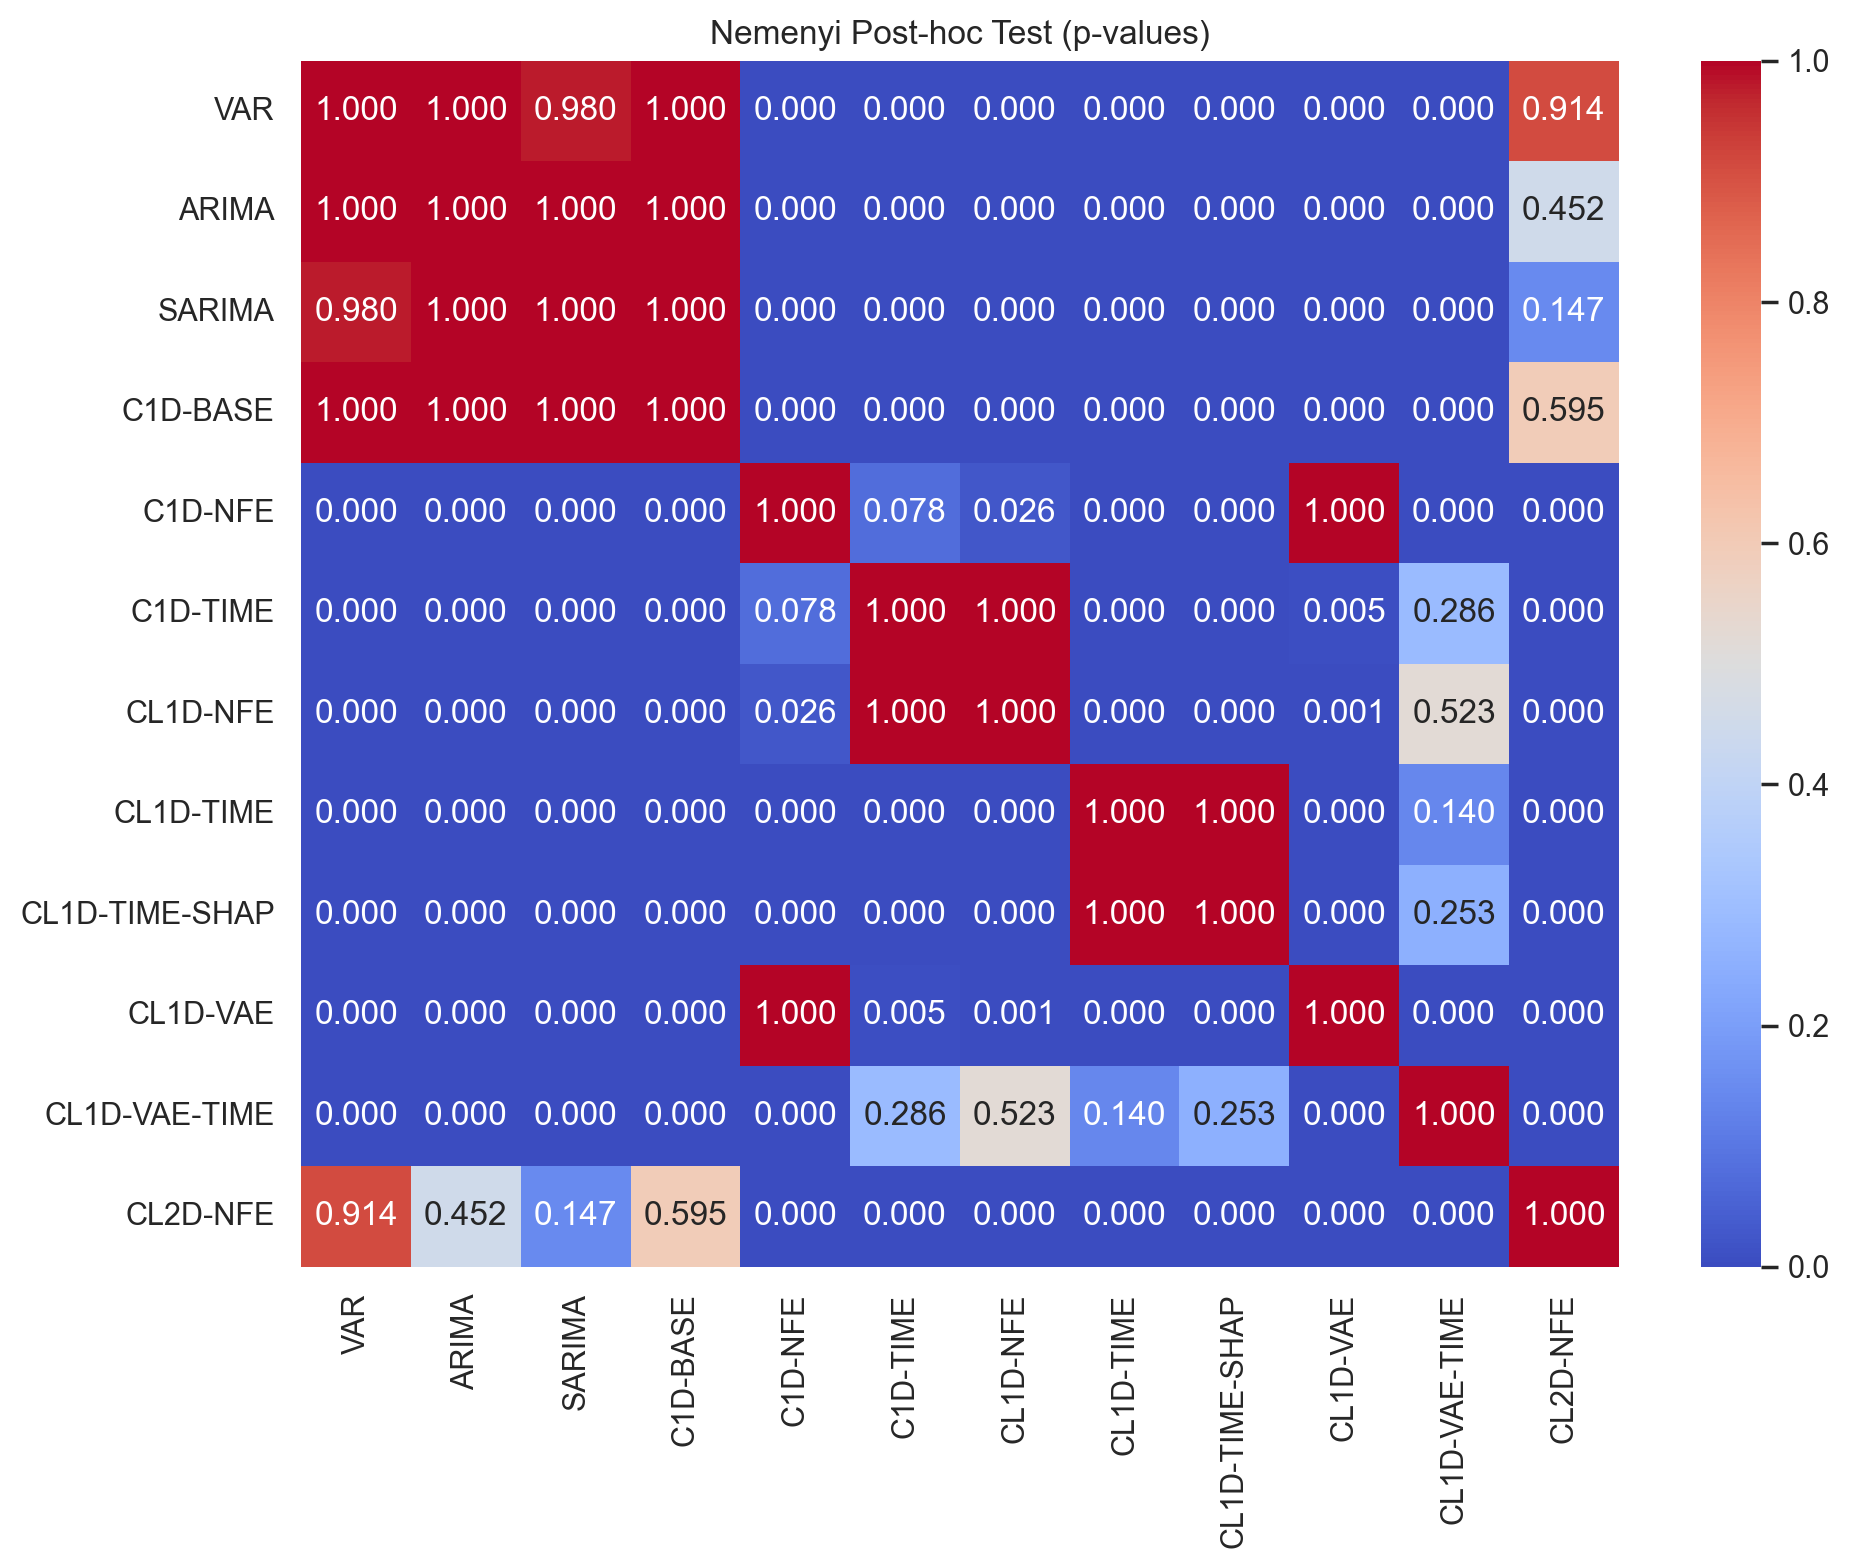

In [78]:


# --- Step 2: Post-hoc test (Nemenyi) ---
nemenyi_results = sp.posthoc_nemenyi_friedman(mae_df.values)
nemenyi_results.columns = mae_df.columns
nemenyi_results.index = mae_df.columns

# Display heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(nemenyi_results, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Nemenyi Post-hoc Test (p-values)")
plt.tight_layout()
plt.show()

# Optional: pairwise Wilcoxon test between specific models
# model_a = "VAR"
# model_b = "CL2D_NFE"
# stat, p = wilcoxon(mae_df[model_a], mae_df[model_b])
# print(f"Wilcoxon test between {model_a} and {model_b}: stat={stat:.4f}, p-value={p:.4e}")


In [80]:

# Prepare results list
wilcoxon_results = []

# Generate all model pairs
model_pairs = list(itertools.combinations(mae_df.columns, 2))

# Perform pairwise Wilcoxon tests
for model_a, model_b in model_pairs:
    try:
        stat, p_value = wilcoxon(mae_df[model_a], mae_df[model_b])
        wilcoxon_results.append({
            'Model A': model_a,
            'Model B': model_b,
            'Wilcoxon Stat': stat,
            'p-value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })
    except Exception as e:
        print(f"Skipped {model_a} vs {model_b}: {e}")

# Convert results to DataFrame
wilcoxon_df = pd.DataFrame(wilcoxon_results).sort_values(by="p-value")
# print(wilcoxon_df)
wilcoxon_df

# Optional: Save to CSV
# wilcoxon_df.to_csv("wilcoxon_model_comparisons.csv", index=False)


Model A         Model B  Wilcoxon Stat       p-value Significant
65  CL1D-VAE-TIME        CL2D-NFE            0.0  3.896560e-18         Yes
23         SARIMA        C1D-TIME            0.0  3.896560e-18         Yes
28         SARIMA   CL1D-VAE-TIME            0.0  3.896560e-18         Yes
33       C1D-BASE       CL1D-TIME            0.0  3.896560e-18         Yes
26         SARIMA  CL1D-TIME-SHAP            0.0  3.896560e-18         Yes
..            ...             ...            ...           ...         ...
56      CL1D-TIME  CL1D-TIME-SHAP         2173.0  2.261675e-01          No
2             VAR        C1D-BASE         2329.0  5.003675e-01          No
45       C1D-TIME        CL1D-NFE         2408.0  6.874750e-01          No
0             VAR           ARIMA         2413.0  7.001690e-01          No
12          ARIMA        C1D-BASE         2500.0  9.314997e-01          No

[66 rows x 5 columns]

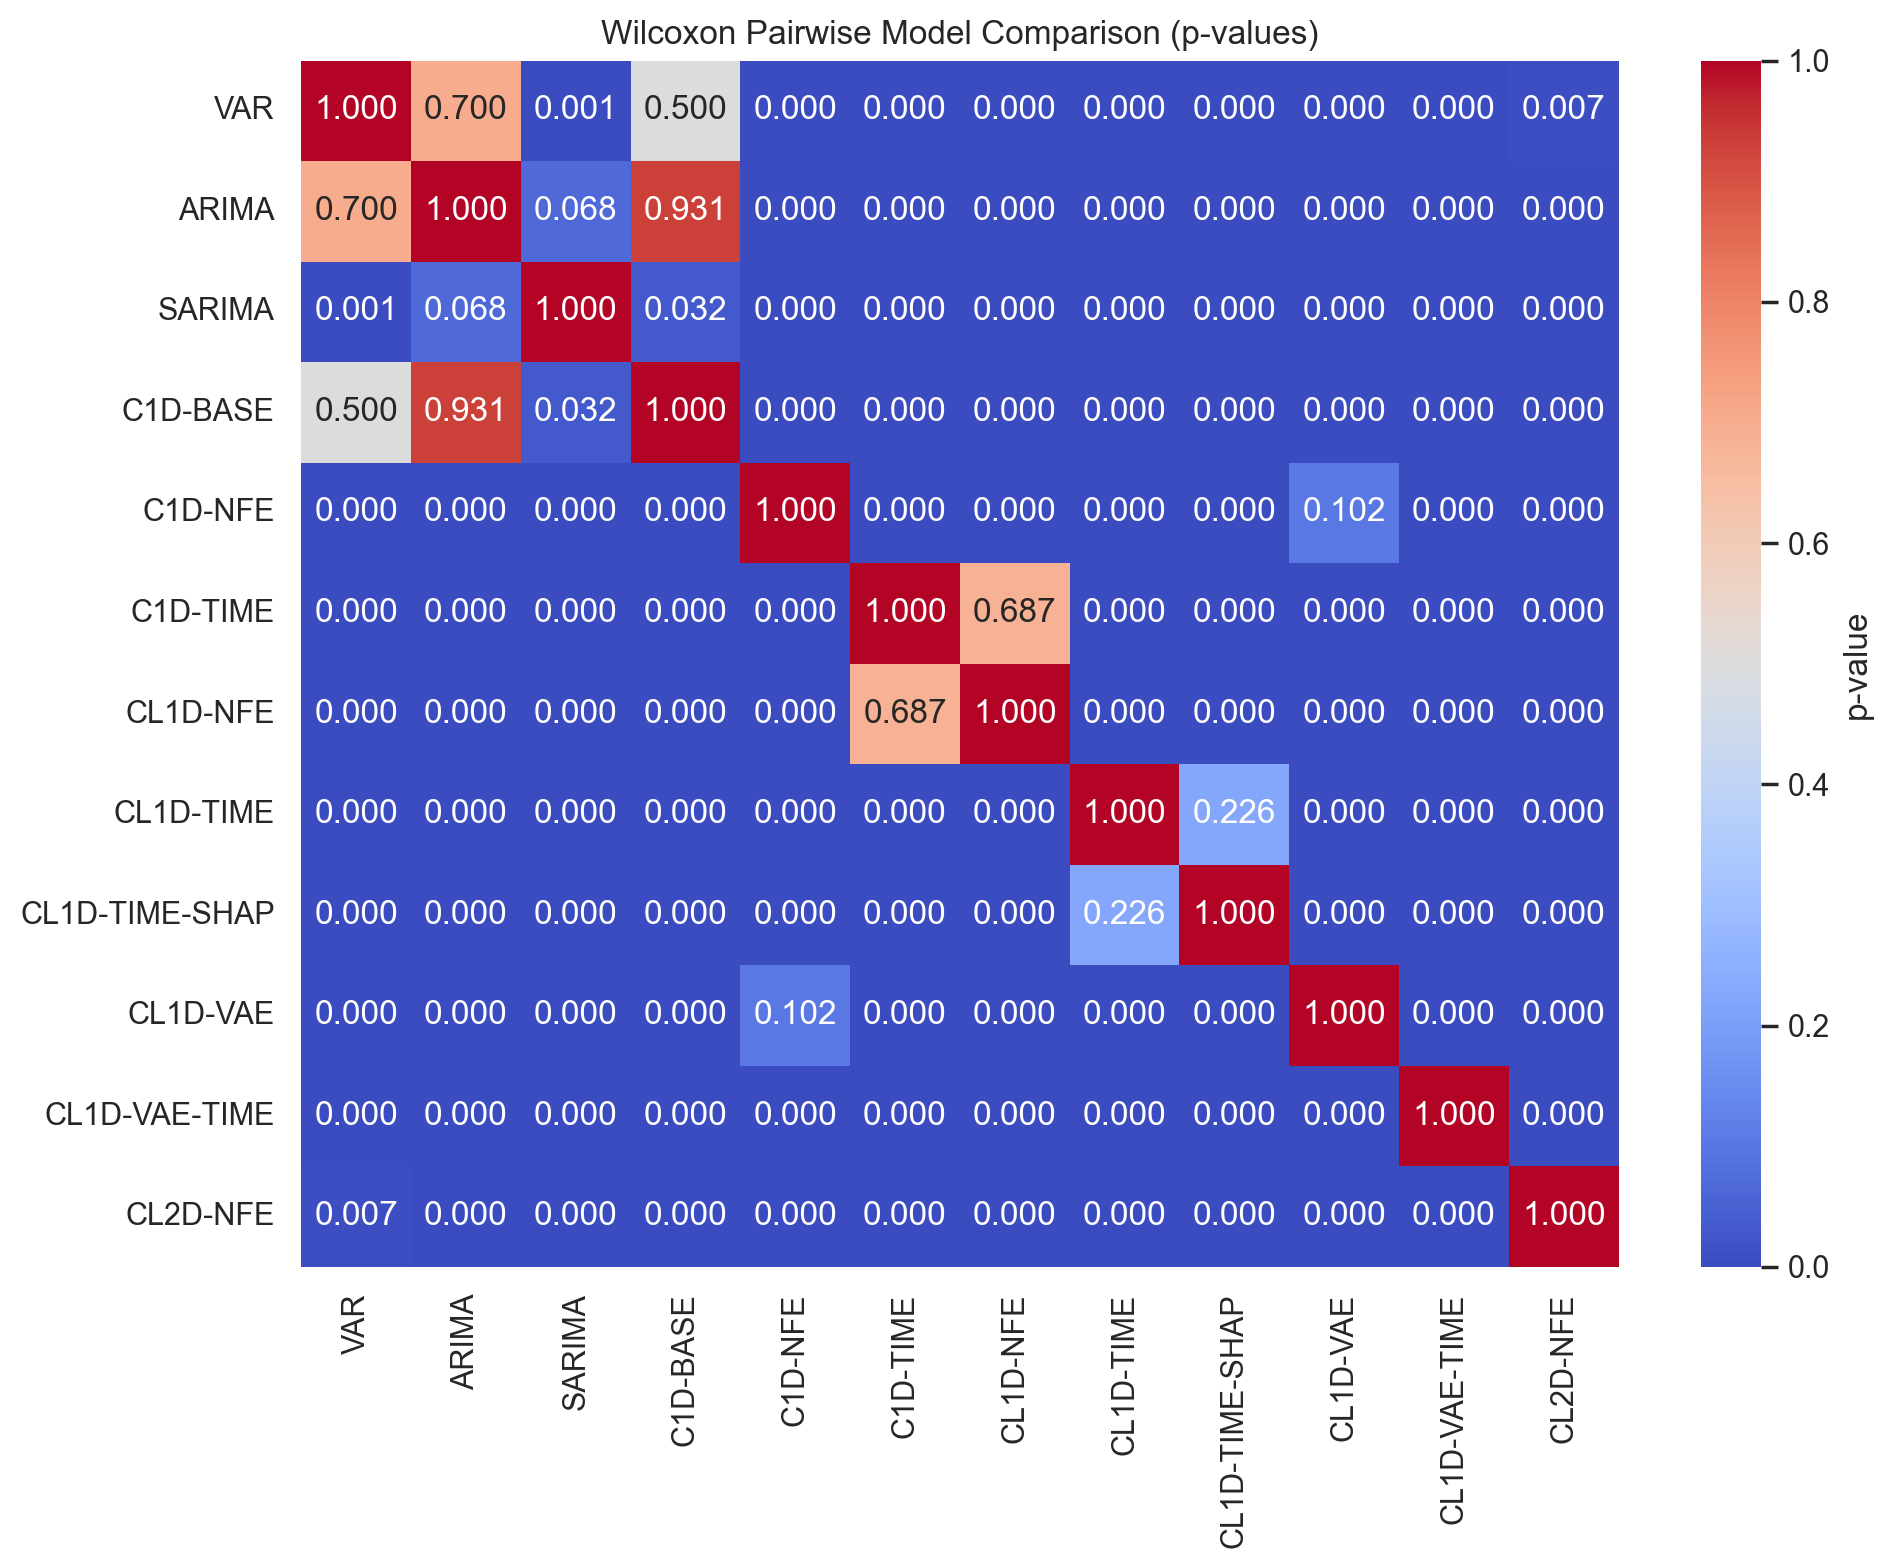

In [81]:

# Create significance matrix
models = mae_df.columns.tolist()
significance_matrix = pd.DataFrame(np.ones((len(models), len(models))), index=models, columns=models)

for _, row in wilcoxon_df.iterrows():
    i, j = row['Model A'], row['Model B']
    significance_matrix.loc[i, j] = row['p-value']
    significance_matrix.loc[j, i] = row['p-value']

# Plot heatmap of p-values
plt.figure(figsize=(10, 8))
sns.heatmap(significance_matrix, annot=True, cmap="coolwarm", fmt=".3f", cbar_kws={"label": "p-value"})
plt.title("Wilcoxon Pairwise Model Comparison (p-values)")
plt.tight_layout()
plt.show()


In [ ]:
model_name_mapper = {
    'sarima': 'SARIMA',
    'arima': 'ARIMA',
    'var': 'VAR',
    'c1d_nfe': 'CONV 1D NFE',
    'cl1d_3lags': 'CONVLSTM 1D 3LAGS FE',
    'cl1d_3lags_shap': 'CONVLSTM 1D 3LAGS + SHAP FE',
    'cl1d_acf': 'CONVLSTM 1D ACF/PACF FE',
    'cl1d_acf_shap': 'CONVLSTM 1D ACF/PACF + SHAP FE',
    'cl2d_nfe': 'CONVLSTM 2D NFE',
    'cl2d_vae': 'CONVLSTM 2D VAE'
}

In [126]:

def plot_model_forecast_errors(forecast_df, model_prefixes, test_size=12, title="Average Forecasts with ±1 Std Dev"):
    """
    Plot average forecast error trajectories for multiple models with confidence intervals.
    Parameters:
    - forecast_df: DataFrame with columns like 'VAR_step1'...'VAR_step12'
    - model_prefixes: List of model name prefixes to plot
    - test_size: Number of forecast steps (e.g., 12 for monthly forecasts)
    - title: Title of the plot
    """

    # Custom colors by model name (lowercase)
    color_map = {
        'cnn': 'blue',
        'cnn_5lags': 'green',
        'cnn_acf_pacf': 'orange',
        'cnn_shap': 'darkred',
        'sarima': 'deeppink',
        'arima': 'indigo',
        'var': 'black',
        'c1d_nfe': 'cornflowerblue',
        'cl1d_3lags': 'darkgreen',
        'cl1d_3lags_shap': 'crimson',
        'cl1d_acf': 'darkorange',
        'cl1d_acf_shap': 'brown',
        'cl2d_nfe': 'slateblue',
        'cl2d_vae': 'teal'
    }

    # Fallback to a color cycle if name not in color map
    fallback_colors = plt.cm.tab10.colors

    plt.figure(figsize=(14, 7))

    for i, model in enumerate(model_prefixes):
        step_cols = [f"{model}_step{j+1}" for j in range(test_size)]
        if not all(col in forecast_df.columns for col in step_cols):
            print(f"[Skipping] {model}: missing forecast steps")
            continue

        model_data = forecast_df[step_cols].values  # Shape: (100, 12)
        mean_forecast = np.mean(model_data, axis=0)
        std_forecast = np.std(model_data, axis=0)

        model_lower = model.lower()
        color = color_map.get(model_lower, fallback_colors[i % len(fallback_colors)])
        label = model.upper()

        x = np.arange(1, test_size + 1)
        plt.plot(x, mean_forecast, label=label,
                 marker='o', linewidth=2, color=color)

    plt.title(title, fontsize=16)
    plt.xlabel("Forecast Horizon (Months Ahead)", fontsize=14)
    plt.ylabel("Forecasted Value", fontsize=14)
    plt.xticks(np.arange(1, test_size + 1))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10, loc='upper right')
    plt.tight_layout()
    plt.show()



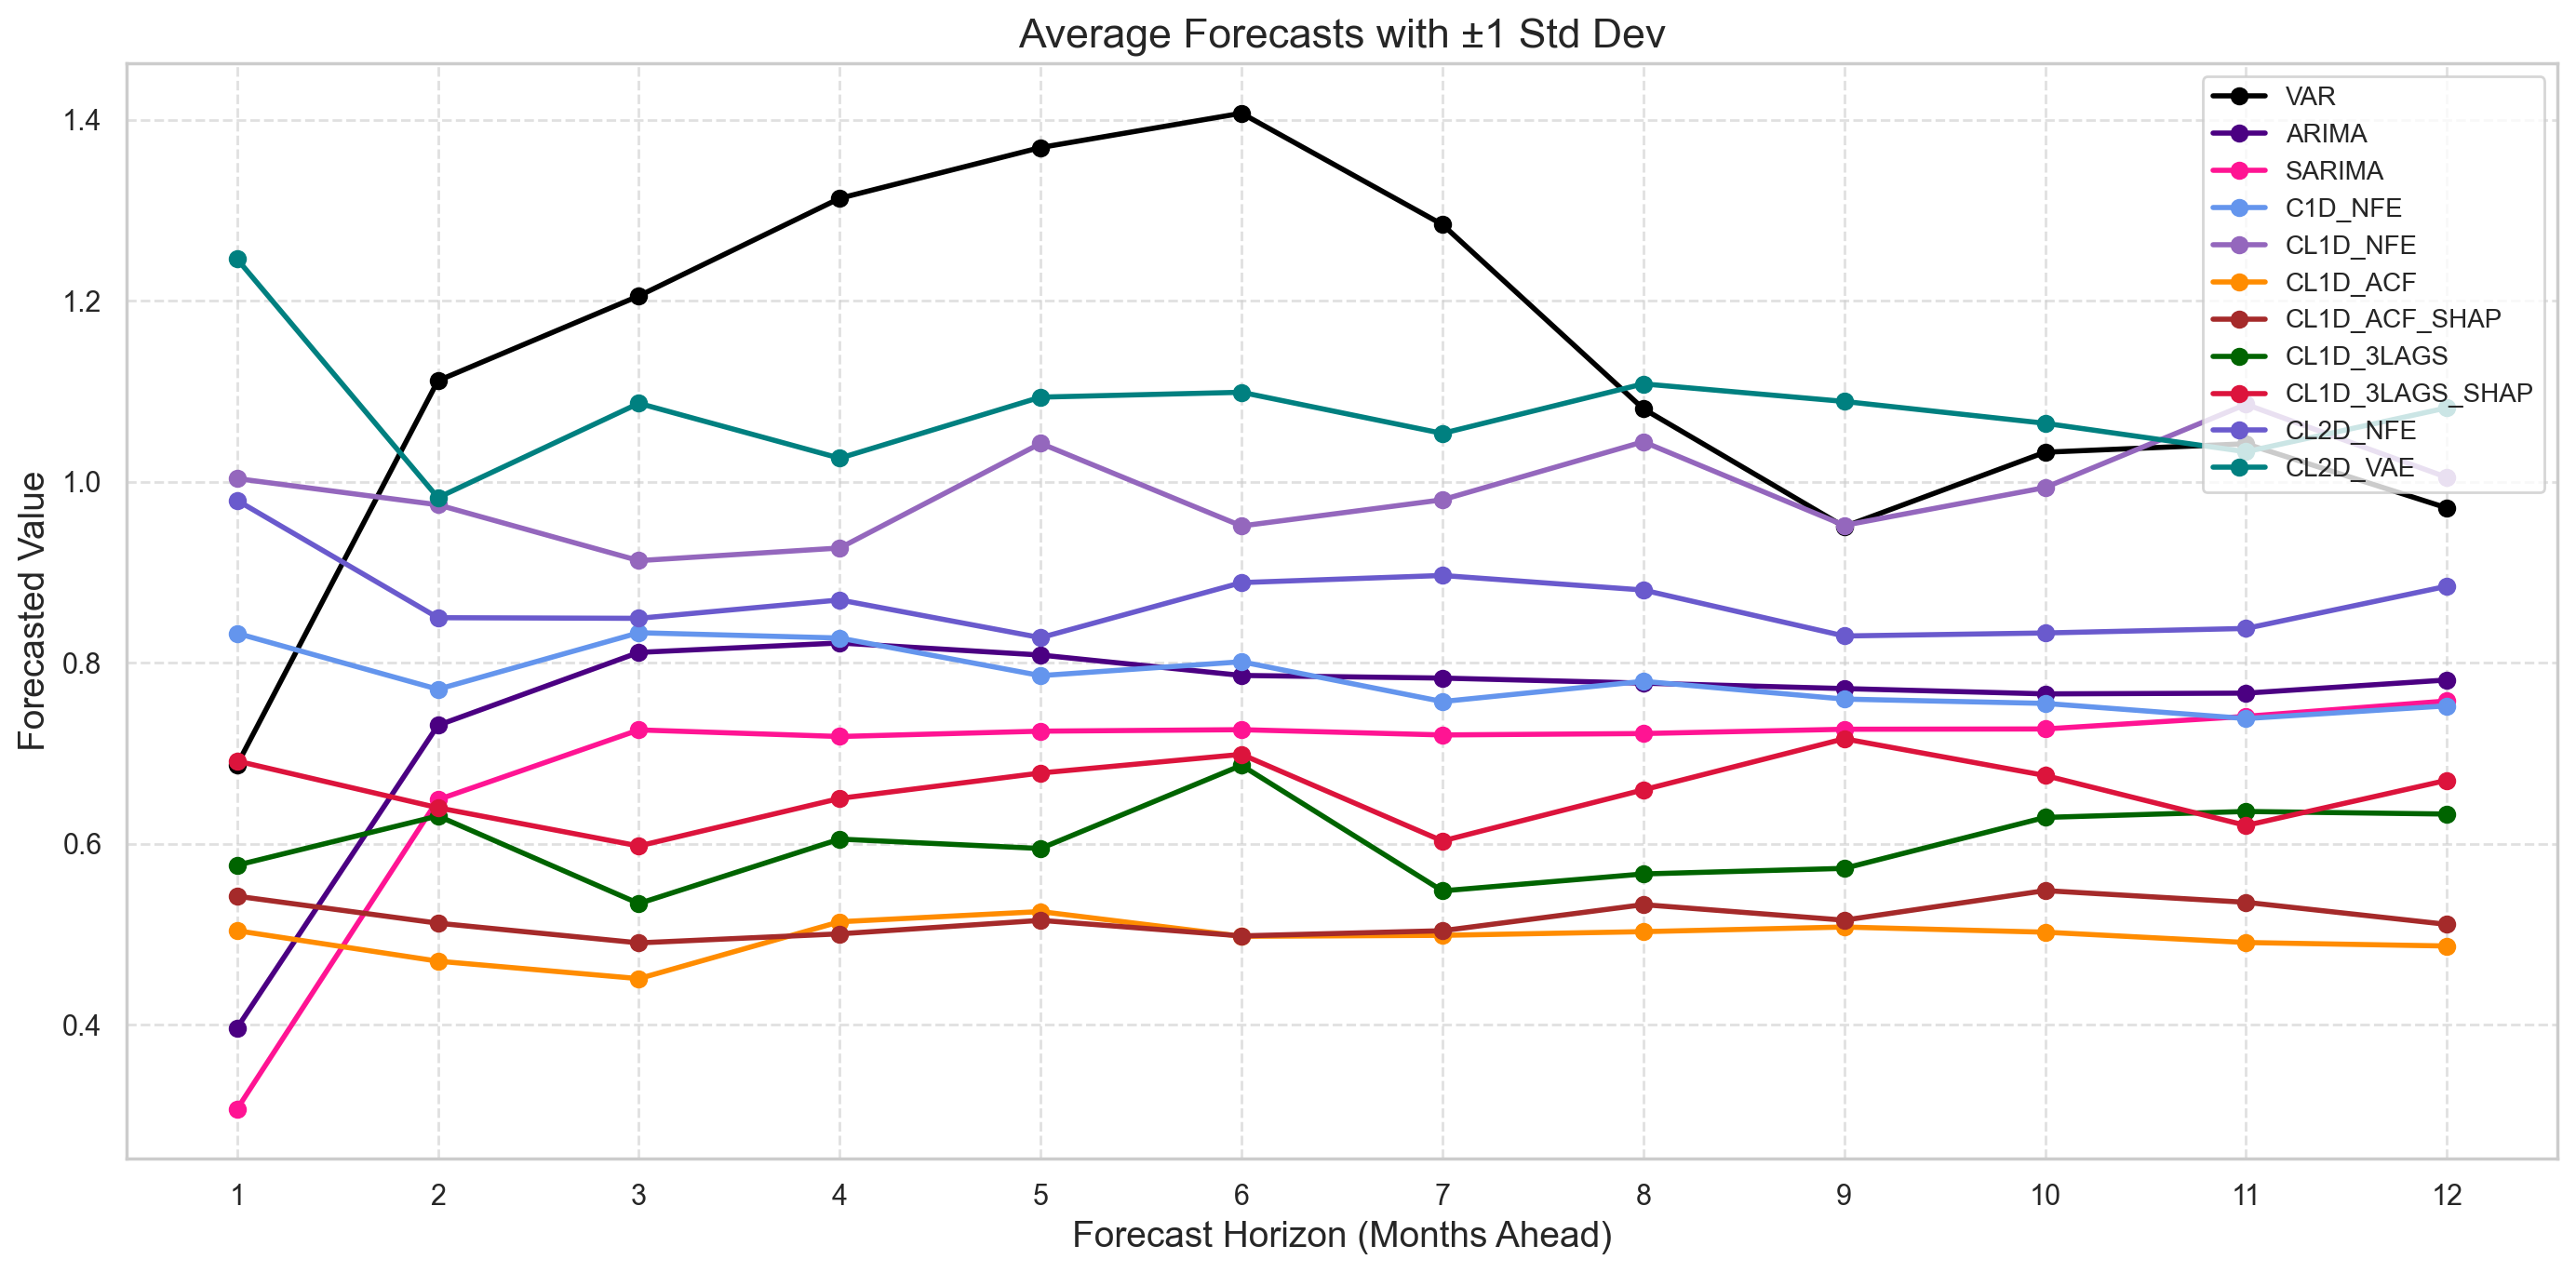

In [127]:
plot_model_forecast_errors(forecast_df, mae_df.columns.tolist())


In [46]:
import math


def plot_multipanel_forecasts_highlighted(forecast_df, model_prefixes, test_size=12, title="Model Forecast Comparison per Step"):
    n_models = len(model_prefixes)
    n_cols = 3
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()
    x = np.arange(1, test_size + 1)

    for i, model in enumerate(model_prefixes):
        ax = axes[i]
        for j, other_model in enumerate(model_prefixes):
            step_cols = [f"{other_model}_step{k+1}" for k in range(test_size)]
            if not all(col in forecast_df.columns for col in step_cols):
                continue

            model_data = forecast_df[step_cols].values
            mean_forecast = np.mean(model_data, axis=0)

            if other_model == model:
                ax.plot(x, mean_forecast, color='blue', linewidth=2, marker='o', label=other_model.upper())
                ax.annotate(f"Mean {mean_forecast[-1]:.2f}",
                            (x[-1], mean_forecast[-1]),
                            textcoords="offset points",
                            xytext=(8, 0),
                            ha='left',
                            fontsize=9,
                            color='blue')
            else:
                ax.plot(x, mean_forecast, color='gray', alpha=0.3)

        ax.set_title(f"{model.upper()}", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.set_xticks(x)

    for ax in axes[n_models:]:
        ax.axis("off")

    fig.suptitle(title, fontsize=16)
    fig.supxlabel("Forecast Horizon (Months Ahead)", fontsize=14)
    fig.supylabel("Forecasted Value", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



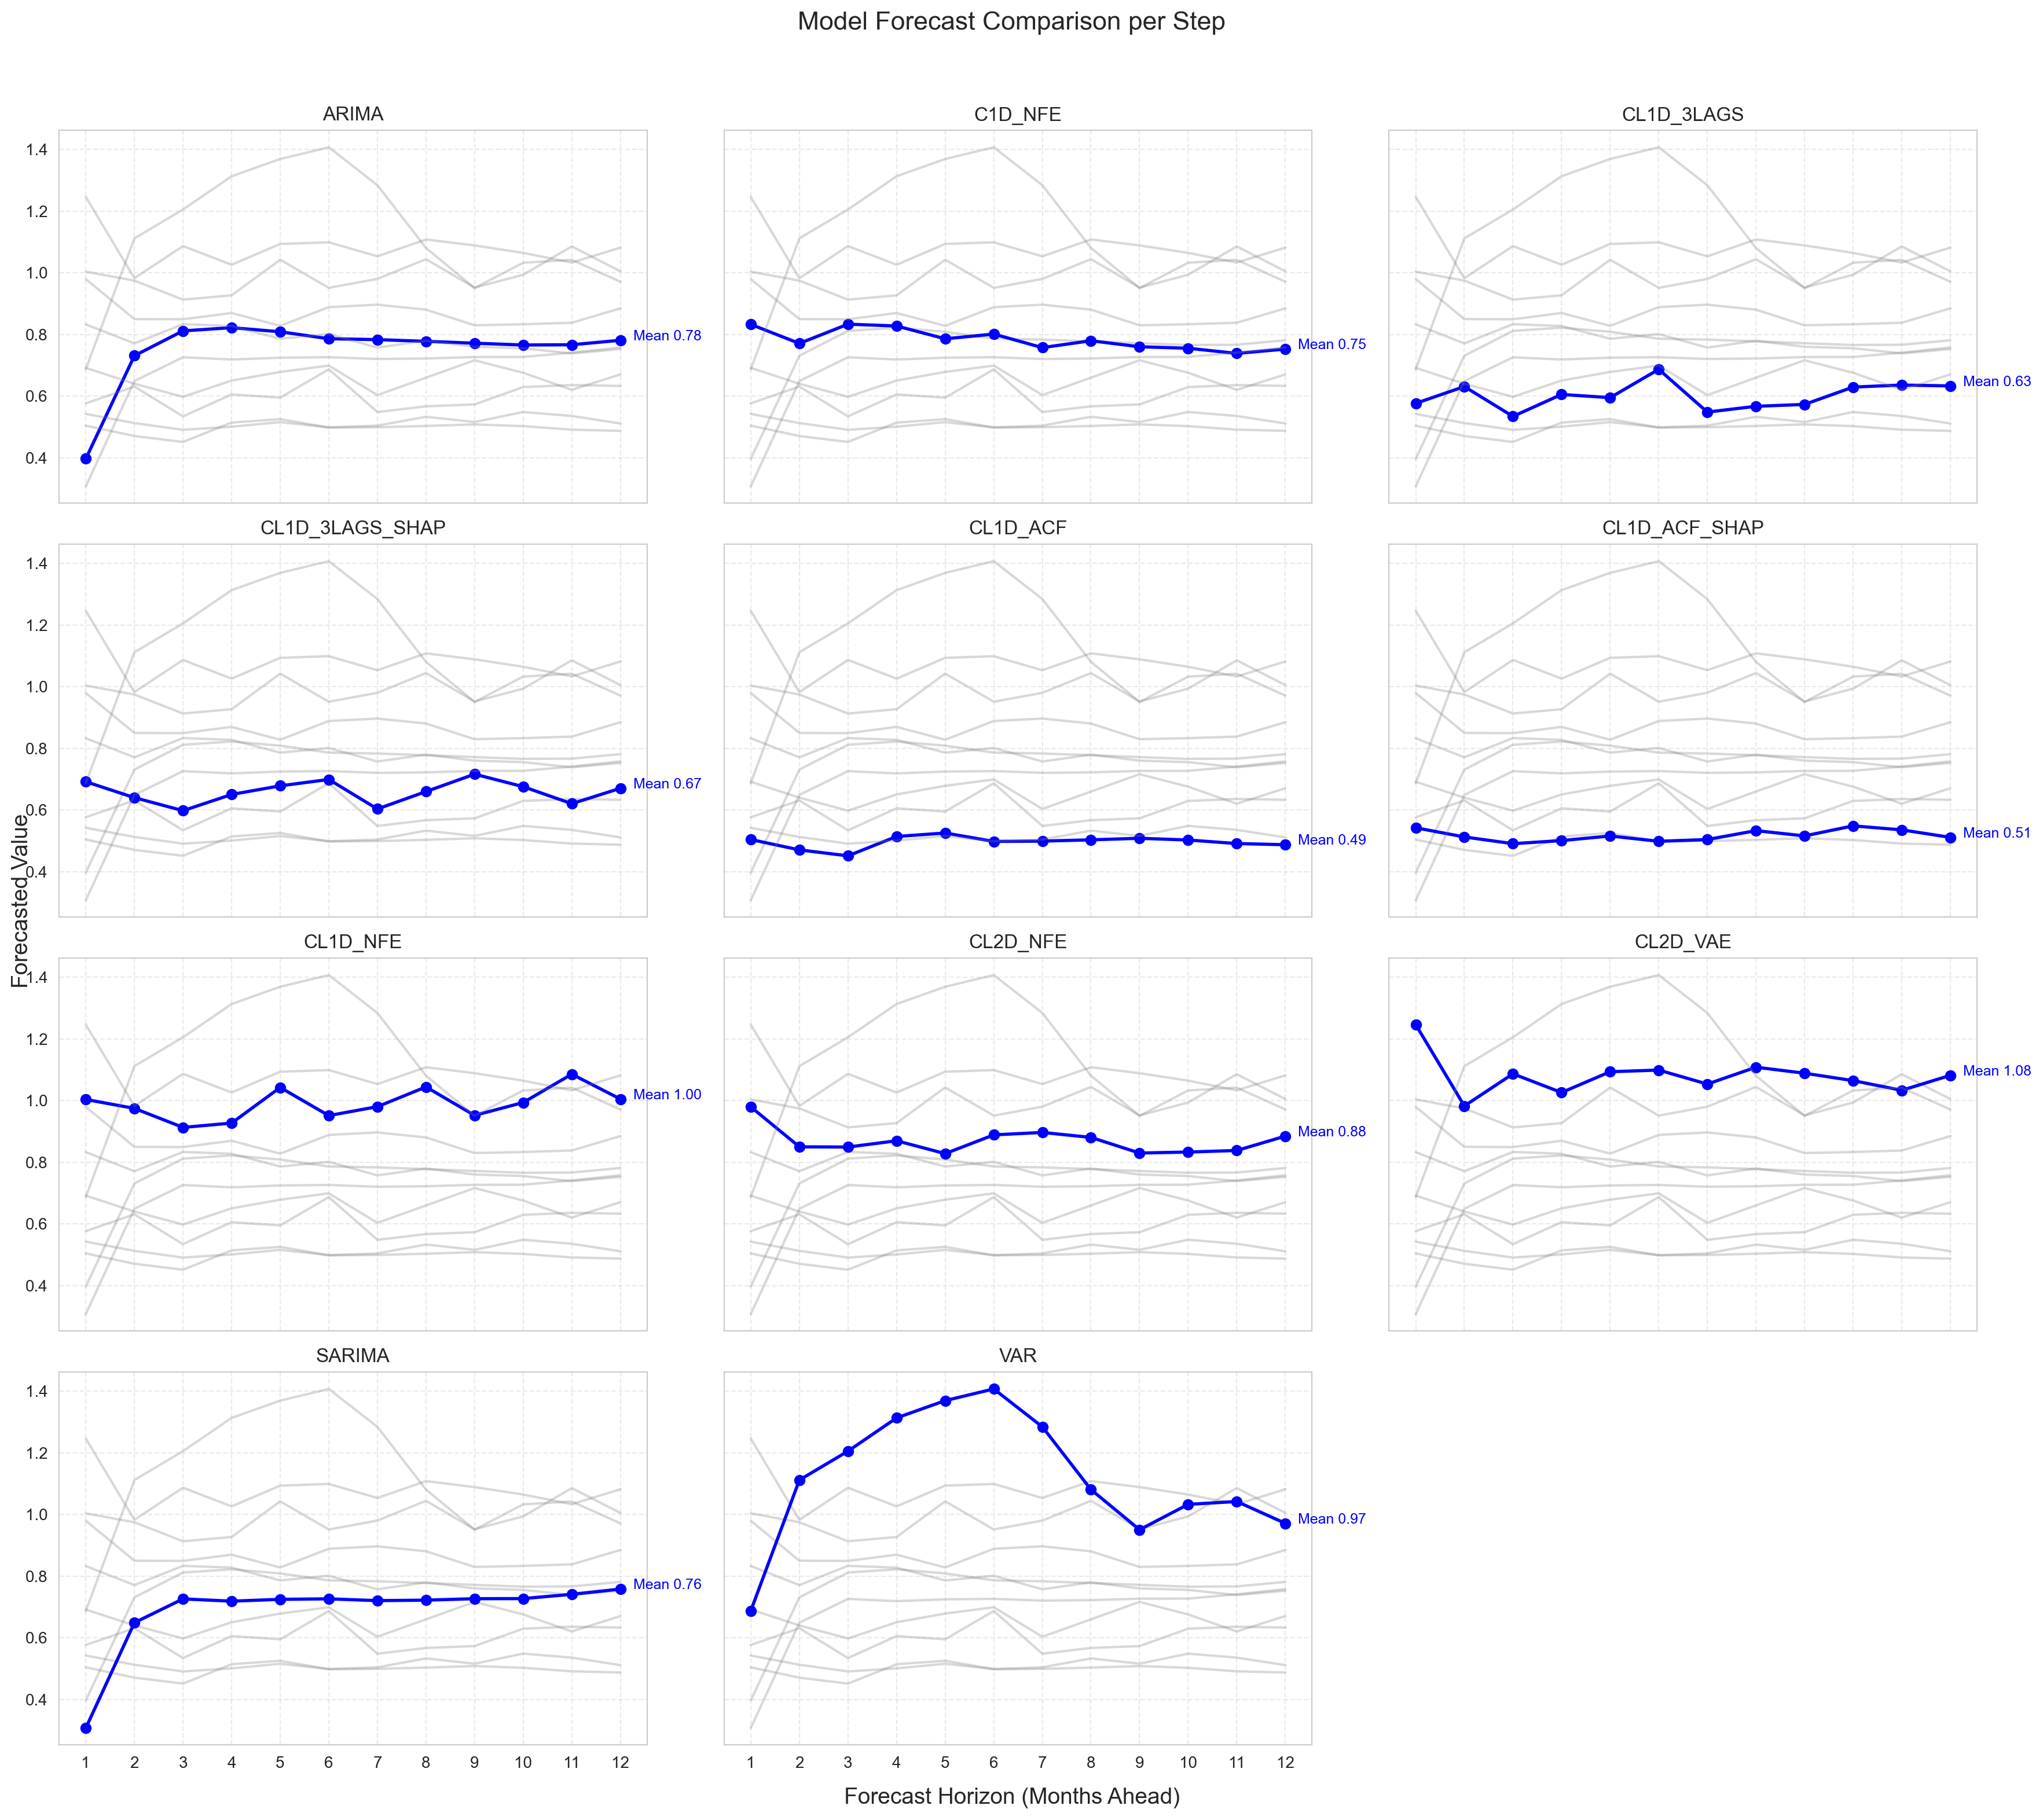

In [47]:
plot_multipanel_forecasts_highlighted(forecast_df, model_prefixes)
